#### Notebook options

In [1]:
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 30em; }</style>"))

In [2]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
### Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}},
 'load_extensions': {'jupyter-js-widgets/extension': True}}

#### Imports

<Figure size 160x160 with 0 Axes>

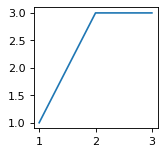

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib as mpl
import os
from JetEtaBins import JetEtaBins, PtBins
from helpers import read_data
# from correction_fitter_helpers import save_correction_txt_file, init_vals_2014, init_two_gaus, fit_corrections

#### some newer versions of pyplot and mplhep, aren't good friends with jupyter
#### To make the plots be formatted directly well, we need to make a dummy plot and rerun the import
### (a very silly solution)
plt.figure(num=None, figsize=(2, 2), dpi=80)
plt.plot([1,2,3],[1,3,3])
import matplotlib.pyplot as plt

In [5]:
from plotters.pltStyle import pltStyle
import mplhep as hep
pltStyle(style='hep')
plt.rcParams['figure.dpi'] = 110

### Fitting the inverse median responses

### Fitting the mean responses

In [6]:
def my_mapping(flav):
    return 'a' if flav=='all' else flav

In [7]:
figdir = "fig/median_correction_fits"

if not os.path.exists(figdir):
    os.mkdir(figdir)

In [8]:
eta_binning  = "HCalPart"  ### HCalPart, JERC, CoarseCalo, CaloTowers, onebin, Summer20Flavor;
eta_binning_str = '_'+eta_binning if eta_binning != "HCalPart" else ''

combine_antiflavour = True
combine_antiflavour_txt = '_split_antiflav' if not combine_antiflavour else ''

jeteta_bins = JetEtaBins(eta_binning, absolute=True)
pt_bins = PtBins("MC_truth")

saveplots = False

In [9]:
from fileNames.available_datasets import legend_labels
ttbarlab = legend_labels['ttbar']['lab']

In [10]:
pltStyle(style='hep')
# plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 110

plt.rcParams['figure.subplot.top'] = 0.93
plt.rcParams['figure.subplot.right'] = 0.96
# pltStyle(style='hep')
# plt.rcParams['figure.subplot.bottom'] = 0.37
plt.rcParams['figure.subplot.left'] = 0.16
plt.rcParams['font.size'] = plt.rcParams['font.size']/1.02

In [11]:
from data_tools import read_or_recreate_data, read_or_recreate_data_txt
from collections.abc import Iterable
out_txt_path = 'out_txt'
def read_data4plot(tag, closure=1, path=out_txt_path):
    '''Read the Mean, MeanStd, Median, MedianStd and RecoPt values of the data with tag `tag`.
    If closure==1, there is no clusure, otherwise it has to be of the same shape as the data read
    '''
#     file_path = f'../out_txt/fit_results_L5_{tag}.json'
#     with open(file_path, 'r') as json_file:
#         json_data = json.load(json_file)
    
    data = read_or_recreate_data(tag, out_txt_path)['data']

    if not isinstance(closure, Iterable):
        closure_tmp = np.array([closure])
    else:
        closure_tmp = np.array(closure).copy()
        closure_tmp[closure_tmp==0] = np.nan
    
    close = ["Median", "Mean"]
    for flav in data:
        for mean_name in close:
            data[flav][mean_name] = data[flav][mean_name]/closure_tmp #[2:]
        for typeii in ["MedianStd", "MeanStd", "MeanRecoPt"]:
            data[flav][typeii] = np.array(data[flav][typeii])

    return data
    

In [12]:
# from collections.abc import Iterable
# out_txt_path = 'out_txt'

# def read_data4plot(flav, tag, closure=1, path=out_txt_path):
#     '''Read the Mean, MeanStd and RecoPt values of the data with tag `tag` and flavor `flav`.
#     If closure==1, there is no clusure, otherwise it has to be of the same shape as the data read '''
#     mean_name = "Median" #or 'Mean'
#     mean_name_std = mean_name+'Std'
#     if not isinstance(closure, Iterable):
#         closure_tmp = np.array([closure])
#     else:
#         closure_tmp = np.array(closure).copy()
#         closure_tmp[closure_tmp==0] = np.nan
#     median = read_or_recreate_data(mean_name, flav, tag, path)/closure_tmp #[2:]
#     median[(median==0) | (np.abs(median)==np.inf)] = np.nan
#     medianstd = read_data(mean_name_std, flav, tag, path) #[2:]
#     reco = read_data("MeanRecoPt", flav, tag, path)
# #     median = 1/median
# #     medianstd = median**2*medianstd
#     return [median, medianstd, reco]

In [13]:
import correction_fitter_helpers as fits

Welcome to JupyROOT 6.28/04


### Individual fits

In [14]:
def do_fits(tags, names, flavors):
    ### Put the minimum limit on the relative uncertainty to min_rel_uncert
    # min_rel_uncert = 0.0005
    min_rel_uncert_relative = 0.05

    fits2plot = { ##name: [function, initial values, # parameters]
#              "MC truth extended": [fits.two_gaus_fnc, [0]*9, 9],
#              "MC truth simp": [fits.response_fnc_simp, [0]*4, 4],
             "Poly, n=4": [fits.poly4, [ 1, 1, 1, 1, 1], 5],
             "Poly, n=3": [fits.poly3, [ 1, 1, 1, 1], 4],
#              "Poly, n=3 + 1/x": [fits.poly3_1_x, [ 1, 1, 1, 1, 1], 5],
             "Poly, n=3 + a/x^b": [fits.poly3_1_xn, [ 1, 1, 1, 1, 0.1, 0.1], 6],    
               }

    closure = read_data("Median", "all", '_L5_QCD-Py'+eta_binning_str)

    fit_res_all_tags = {}
    for data_tag, data_name in np.transpose([tags, names]):
        fit_res_all = {}

        for flav in flavors:
            fit_res = []
            ## if fit flavor-antiflavor, closure by the L5 correction
            if not combine_antiflavour:
                flav2 = flav[:-3] if 'bar' in flav else flav
                closure = read_data("Median", flav2, data_tag[:-len(combine_antiflavour_txt)])
            data = {data_tag: read_data4plot(data_tag, closure=closure )[flav]}

            for etaidx in range(jeteta_bins.nbins):
                print('Fitting subsample: ', flav, f'Eta idx = {etaidx}, eta bin = [{jeteta_bins.edges[etaidx]}; {jeteta_bins.edges[etaidx+1]} ]', )
                fit_res_new = fits.fit_corrections(etaidx, data, flav=flav, data_tags=[data_name],
                                                     fits2plot=fits2plot, main_fit="Poly, n=4",
                                  figdir2=figdir,
                                  jeteta_bins=jeteta_bins, pt_bins=pt_bins,
                                  plot_initial_val=[0],
                                  use_recopt=True,
                                  maxlimit_static_pnt=False,
                                  min_pt_val=15,
    #                               max_ptval=4000,
                                  min_rel_uncert_relative=min_rel_uncert_relative,
                                  show_original_errorbars=True,
                                  saveplots=False,
                                                  ncoefs_out=6)

                fit_res = np.concatenate([fit_res, fit_res_new])

            num = int(5 + fit_res[2])
            fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
            correction_name = my_mapping(flav)
            correction_name += 'T' if 'TTBAR' in data_tag else 'J' 
            fit_res_all[correction_name] = fit_res
        fit_res_all_tags[data_tag] = fit_res_all
        
    return fit_res_all_tags

In [15]:
def do_fits_simfit(tags, names, colors, flavors):
    ### Put the minimum limit on the relative uncertainty to min_rel_uncert
    min_rel_uncert = 0.0005
    min_rel_uncert_relative = 0.01

    fits2plot = { ##name: [function, initial values, # parameters]
                 "Poly, n=4": [fits.poly4, [ 1, 1, 1, 1, 1], 5],
                 "Poly, n=3 + a/x^b": [fits.poly3_1_xn, [ 1, 1, 1, 1, 0.1, 0.1], 6],
    #              "Poly, n=3": [fits.poly3, [ 1, 1, 1, 1], 4],
                 }

    closure = read_data("Median", "all", '_L5_QCD-Py'+eta_binning_str)

    fit_res_all = {}

    for flav in flavors:
        fit_res = []
        if not combine_antiflavour:
            flav2 = flav[:-3] if 'bar' in flav else flav
            closure = read_data("Median", flav2, data_tag[:-len(combine_antiflavour_txt)])
        data = {tag: read_data4plot(tag, closure=closure )[flav] for tag in tags}
        
        for etaidx in range(jeteta_bins.nbins):
            print('Fitting flavor: ', flav, f'Eta idx = {etaidx}, eta bin = [{jeteta_bins.edges[etaidx]}; {jeteta_bins.edges[etaidx+1]} ]', )
            fit_res_new = fits.fit_corrections(etaidx, data, flav=flav, data_tags=names,
                                  fits2plot=fits2plot, main_fit="Poly, n=4",
                                  figdir2=figdir,
                                  jeteta_bins=jeteta_bins, pt_bins=pt_bins,
                                  plot_initial_val=["Mikko fun ud"],
                                  use_recopt=True,
                                  min_pt_val=17,
                                  maxlimit_static_pnt=True,
                                  min_rel_uncert_relative=min_rel_uncert_relative,
                                  show_original_errorbars=True,
                                  inflate_smallest_std_bool=True,
                                  saveplots=False,
                                  colors=colors)

            fit_res = np.concatenate([fit_res, fit_res_new])

        num = int(5 + fit_res[2])
        fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
        correction_name = my_mapping(flav)+'S'
        fit_res_all[correction_name] = fit_res

    return fit_res_all

In [16]:
def merge_DY_QCD(data, tags, pt_merge=60):
    ''' Merge DY up to 60 GeV and QCD from 60 GeV. A method recommended by Mikko.
    '''
    QCD_tag = tags[np.where(['QCD' in tag for tag in tags])[0][0]]
    DY_tag = tags[np.where(['DY' in tag for tag in tags])[0][0]]
    dataQCD = data[QCD_tag]
    dataDY = data[DY_tag]
    merge_idx = pt_bins.get_bin_idx(pt_merge)

    data_merged = {}
    for key in dataQCD:
        data_merged[key] = np.vstack([dataDY[key][:merge_idx,:], dataQCD[key][merge_idx:,:]])
    return {QCD_tag: dataQCD, DY_tag: dataDY, "merged": data_merged}

In [17]:
0.0005/0.02

0.025

In [69]:
def do_fits_simfit_Mikko(tags, names, colors, flavors):
    ### Put the minimum limit on the relative uncertainty to min_rel_uncert
    min_rel_uncert = 0.0006
    min_rel_uncert_relative = 0.022

    ##### ud fit
    fits2plot = { ##name: [function, initial values, # parameters]
                 "Poly, n=4": [fits.poly4, [ 1, 1, 1, 1, 1], 5],
                 "Mikko fun py": [fits.Mikko_fun_ud,[0.8657 ,-0.8604 ,-0.2572 ,0.2917 ,-0.1611 ,0.8742], 6],  #[0.8657 ,-0.8603 ,-0.2572 ,0.2917 ,-0.1611 ,0.8741], 6],
                 "Mikko fun ud": [None, [0.8657 ,-0.8604 ,-0.2572 ,0.2917 ,-0.1611 ,0.8742], 6, None, fits.Mikkofun_ud], 
                 }

    closure = read_data("Median", "all", '_L5_QCD-Py'+eta_binning_str)

    fit_res_all = {}

    for flav in ['ud']:
        fit_res = []
        if not combine_antiflavour:
            flav2 = flav[:-3] if 'bar' in flav else flav
            closure = read_data("Median", flav2, data_tag[:-len(combine_antiflavour_txt)])
        data = {tag: read_data4plot(tag, closure=closure )[flav] for tag in tags}
        data_merged = merge_DY_QCD(data, tags)

        for etaidx in range(jeteta_bins.nbins):

            print('Fitting flavor: ', flav, f'Eta idx = {etaidx}, eta bin = [{jeteta_bins.edges[etaidx]}; {jeteta_bins.edges[etaidx+1]} ]', )
            fit_res_new = fits.fit_corrections(etaidx, data_merged, flav=flav, data_tags=names,
                                  fits2plot=fits2plot, main_fit="Mikko fun ud",
                                  figdir2=figdir,
                                  jeteta_bins=jeteta_bins, pt_bins=pt_bins,
                                  plot_initial_val=[],
                                  ncoefs_out=6,
                                  use_recopt=True,
                                  inverse=False,
                                  min_pt_val=17,
                                  maxlimit_static_pnt=False,
                                  min_rel_uncert_relative=min_rel_uncert_relative,
                                  show_original_errorbars=False,
                                  inflate_smallest_std_bool=True,
                                  saveplots=True,
                                  colors=colors,
                                  fit_sample=2)

            fit_res = np.concatenate([fit_res, fit_res_new])
            

        num = int(5 + fit_res[2])
        fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
        fit_res_ud = fit_res.copy()
        correction_name = my_mapping(flav)+'M'
        fit_res_all[correction_name] = fit_res
    
    flavors = [flav for flav in flavors if 'ud' not in flav]
    merge_pt = {flav: 60 for flav in flavors}
    merge_pt['b'] = 15
    merge_pt['c'] = 15
    merge_pt['all'] = 15
    closure_ud = data_merged.copy()
        
    ##### s fit
    fits2plot = { ##name: [function, initial values, # parameters, ROOT string]
             "Poly, n=4": [fits.poly4, [ 1, 1, 1, 1, 1], 5],
             "Mikko fun py": [fits.Mikko_fun2,[-1,-0.7, -0.025,np.log(150.),0.3], 5],  #[0.8657 ,-0.8603 ,-0.2572 ,0.2917 ,-0.1611 ,0.8741], 6],
             "Mikko fun s": [None, [-0.35,-0.17, -0.025,np.log(150.),0.3], 5, [None, None,None, [np.log(2),np.log(200)],None], fits.Mikkofun_s], 
             }
    
    for flav in 's':
        fit_res = []
        if not combine_antiflavour:
            flav2 = flav[:-3] if 'bar' in flav else flav
            closure = read_data("Median", flav2, data_tag[:-len(combine_antiflavour_txt)])
        data = {tag: read_data4plot(tag, closure=closure*closure_ud['merged']['Median'] )[flav] for tag in tags}
        data = merge_DY_QCD(data, tags, merge_pt[flav])

        for etaidx in range(jeteta_bins.nbins):

            print('Fitting flavor: ', flav, f'Eta idx = {etaidx}, eta bin = [{jeteta_bins.edges[etaidx]}; {jeteta_bins.edges[etaidx+1]} ]', )
            fit_res_new = fits.fit_corrections(etaidx, data, flav=flav, data_tags=names,
                                  fits2plot=fits2plot, main_fit="Mikko fun s",
                                  figdir2=figdir,
                                  jeteta_bins=jeteta_bins, pt_bins=pt_bins,
#                                   plot_initial_val=["Mikko fun s"],
                                  ncoefs_out=5,
                                  use_recopt=True,
                                  inverse=False,
                                  min_pt_val=17,
                                  min_rel_uncert=min_rel_uncert,
                                  maxlimit_static_pnt=False,
#                                   min_rel_uncert_relative=min_rel_uncert_relative,
                                  show_original_errorbars=True,
                                  inflate_smallest_std_bool=True,
                                  saveplots=True,
                                  colors=colors,
                                  fit_sample=2,
                                  custom_jet_legend=f's/ud jets')

            fit_res = np.concatenate([fit_res, fit_res_new, fit_res_ud[etaidx][5:]])

        num = int(5 + fit_res[2]+6)
        fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
        fit_res[:,2] = fit_res[:,2]+6
        correction_name = my_mapping(flav)+'M'
        fit_res_all[correction_name] = fit_res
        
    flavors = [flav for flav in flavors if 's' not in flav]
    fits2plot = { ##name: [function, initial values, # parameters, ROOT string]
             "Poly, n=4": [fits.poly4, [ 1, 1, 1, 1, 1], 5],
             "Mikko fun py": [fits.Mikko_fun1,[-1,-0.3,0.01,0.0001], 4],  #[0.8657 ,-0.8603 ,-0.2572 ,0.2917 ,-0.1611 ,0.8741], 6],
             "Mikko fun": [None, [-1,-0.3,0.01,0.0001], 4, None, fits.Mikkofun], 
             }
    
    for flav in flavors:
        fit_res = []
        if not combine_antiflavour:
            flav2 = flav[:-3] if 'bar' in flav else flav
            closure = read_data("Median", flav2, data_tag[:-len(combine_antiflavour_txt)])
        data = {tag: read_data4plot(tag, closure=closure*closure_ud['merged']['Median'] )[flav] for tag in tags}
        data = merge_DY_QCD(data, tags, merge_pt[flav])

        for etaidx in range(jeteta_bins.nbins):

            print('Fitting flavor: ', flav, f'Eta idx = {etaidx}, eta bin = [{jeteta_bins.edges[etaidx]}; {jeteta_bins.edges[etaidx+1]} ]', )
            fit_res_new = fits.fit_corrections(etaidx, data, flav=flav, data_tags=names,
                                  fits2plot=fits2plot, main_fit="Mikko fun",
                                  figdir2=figdir,
                                  jeteta_bins=jeteta_bins, pt_bins=pt_bins,
#                                   plot_initial_val=["Mikko fun"],
                                  ncoefs_out=4,
                                  use_recopt=True,
                                  inverse=False,
                                  min_pt_val=17,
                                  maxlimit_static_pnt=False,
                                  min_rel_uncert_relative=min_rel_uncert_relative,
                                  show_original_errorbars=True,
                                  inflate_smallest_std_bool=True,
                                  saveplots=True,
                                  colors=colors,
                                  fit_sample=2,
                                  custom_jet_legend=f'{flav}/ud jets')

            fit_res = np.concatenate([fit_res, fit_res_new, fit_res_ud[etaidx][5:]])

        num = int(5 + fit_res[2]+6)
        fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
        fit_res[:,2] = fit_res[:,2]+6
        correction_name = my_mapping(flav)+'M'
        fit_res_all[correction_name] = fit_res
    
    return fit_res_all

In [70]:
from uncertainty_plotters import color_scheme

In [93]:
correction_for = 'Her' #'Py', 'Her' or 'Py_MGQCD' , 'Her_MGQCD'

unc_eta_str = '_'+eta_binning if eta_binning != "Summer20Flavor" else ''
if correction_for == 'Py_MGQCD':
    tags, names = ['_L5_QCD-MG-Py', '_L5_Pythia-TTBAR'], ['QCD, MG+Py8', f"{ttbarlab} Pow+Py8"]
    tags_simfit, names_simfit = ['_L5_QCD-MG-Py', '_L5_Pythia-TTBAR', '_L5_DY-MG-Py'], ['QCD, MG+Py8', f"{ttbarlab} Pow+Py8", 'DY, MG+Py8']
    colors=None
    txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MGQCD{combine_antiflavour_txt}{unc_eta_str}.txt'
elif correction_for == 'Her_MGQCD':
    tags, names = ['_L5_QCD-MG-Her', '_L5_Herwig-TTBAR', '_L5_DY-MG-Her'], ['QCD, MG+Her7', f"{ttbarlab} Pow+Her7", 'DY, MG+Her7']
    tags_simfit = tags
    names_simfit = names
    txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MGQCD{combine_antiflavour_txt}{unc_eta_str}.txt'
elif correction_for == 'Her':
    txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_Her{combine_antiflavour_txt}{unc_eta_str}.txt'
    tags, names = ['_L5_Herwig-TTBAR', '_L5_DY-MG-Py'], ['QCD, MG+Her7', f"{ttbarlab} Pow+Her7"]
    tags_simfit, names_simfit = ['_L5_Herwig-TTBAR', '_L5_DY-MG-Her'], [f"{ttbarlab} Pow+Her7", 'DY, MG+Her7']
    tags_simfitMikko, names_simfitMikko = ['_L5_QCD-MG-Her', '_L5_DY-MG-Her'], ['QCD, MG+Her7', 'DY, MG+Her7']
    colors = {names[0]: color_scheme['TTBAR']['color'], names[1]:color_scheme['DY']['color']}
elif correction_for == 'Py':
    txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs{combine_antiflavour_txt}{unc_eta_str}.txt'
    tags, names =  ['_L5_QCD-MG-Py', '_L5_Pythia-TTBAR'], ['QCD, MG+Py8', f"{ttbarlab} Pow+Py8"]
    tags_simfit, names_simfit = ['_L5_QCD-Py', '_L5_Pythia-TTBAR', '_L5_DY-MG-Py'], ['QCD, Py8', f"{ttbarlab}, Pow+Py8", 'DY, MG+Py8']
    tags_simfitMikko, names_simfitMikko = ['_L5_QCD-MG-Py', '_L5_DY-MG-Py'], ['QCD, MG+Py8', 'DY, MG+Py8']
    colors = {names[0]: color_scheme['QCD']['color'], names[1]: color_scheme['TTBAR']['color'], names[2]:color_scheme['DY']['color']}
else:
    raise ValueError("Please provide correction_for from ['Py', 'Her', 'Her_MGQCD' or 'Py_MGQCD']")
tags = [tag+eta_binning_str+combine_antiflavour_txt for tag in tags]

In [94]:
if not combine_antiflavour:
    flavors = ['bbar', 'b', 'c', 's', 'ud', 'q', 'cbar', 'sbar', 'udbar', 'qbar']
else:
    flavors = ['b', 'c', 'g', 's', 'ud', 'q', 'u', 'd', 'all']
# flavors = ['b', 'c', 'g', 's', 'ud', 'all', 'unmatched']
# flavors = ['ud']

In [95]:
# tags_simfit

In [96]:
# from scipy.stats import chi2
# chi2.ppf(1-0.158, 24)

In [97]:
# read_data4plot(tags_simfit[0], 1, 'out_txt')

In [98]:
# fit_res_all_tags = do_fits(tags, names, flavors) #:-1 to exclude DY
# fit_res_all_tags['simfit'] = do_fits_simfit(tags_simfit, names_simfit, colors, flavors)
# do_fits_simfit_Mikko(tags_simfit, names_simfit, colors, flavors)

In [99]:
# fit_res_all_tags['Mikko'] 

In [100]:
# a = do_fits_simfit_Mikko(tags_simfit, [names_simfit[0], names_simfit[2],"merged"], colors=None, flavors=flavors)

Read data from  out_txt/response_fit_results_L5_Herwig-TTBAR.json
Fitting subsample:  b Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0012601097550445197
Using the Poly, n=4 fit results 


/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/correction_fitter_helpers.py:203: RuntimeWarning: overflow encountered in power
  res = c0+c1*xs+c2*xs**2+c3*xs**3+c4/xs**c5
/cvmfs/sft.cern.ch/lcg/views/LCG_104/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


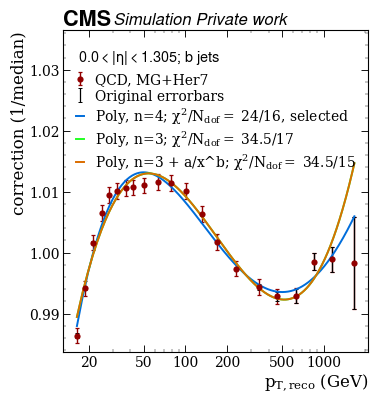

Fitting subsample:  b Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.0027821230562472266
Using the Poly, n=3 fit results 


/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/correction_fitter_helpers.py:203: RuntimeWarning: divide by zero encountered in divide
  res = c0+c1*xs+c2*xs**2+c3*xs**3+c4/xs**c5
/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/correction_fitter_helpers.py:203: RuntimeWarning: overflow encountered in divide
  res = c0+c1*xs+c2*xs**2+c3*xs**3+c4/xs**c5


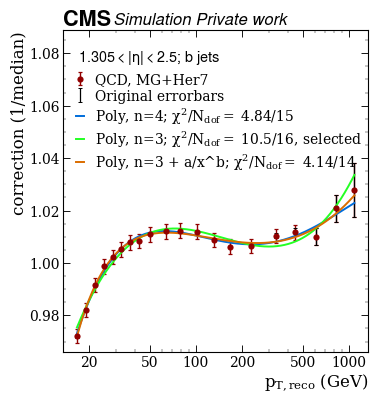

Fitting subsample:  b Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0013547611403295857
Using the Poly, n=4 fit results 


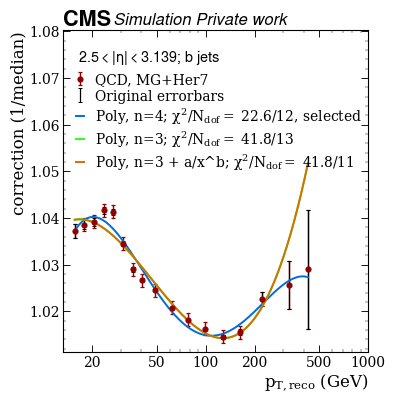

Fitting subsample:  b Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0017517833050172628
Using the Poly, n=4 fit results 


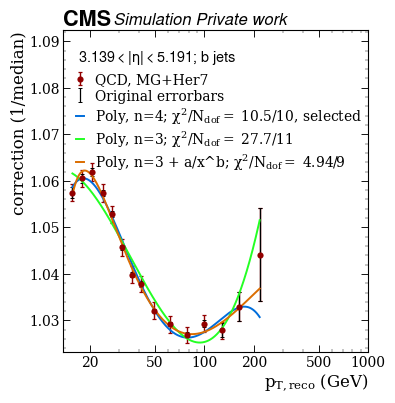

Read data from  out_txt/response_fit_results_L5_Herwig-TTBAR.json
Fitting subsample:  c Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.001329491205198835
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


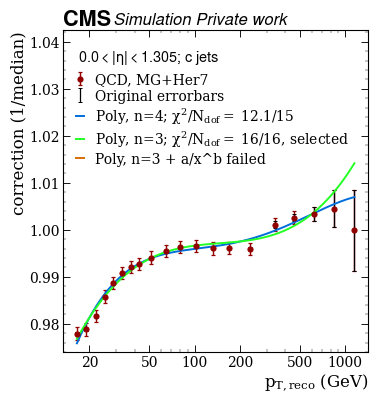

Fitting subsample:  c Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.0027412995517637154
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


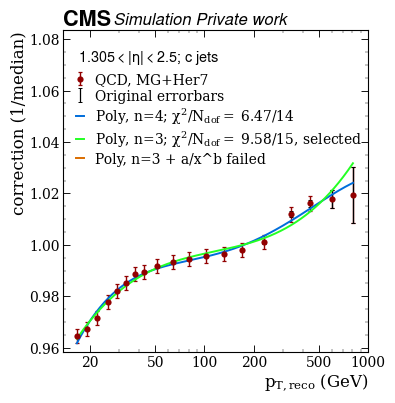

Fitting subsample:  c Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0016587651352465817
Using the Poly, n=4 fit results 


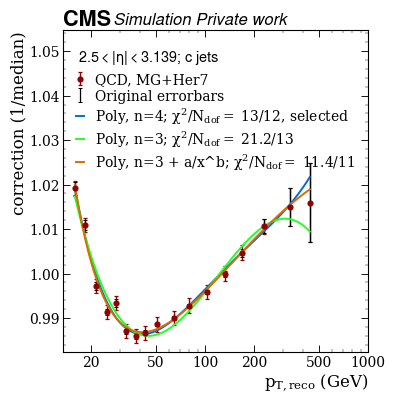

Fitting subsample:  c Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0015920122753649735
Using the Poly, n=3 fit results 


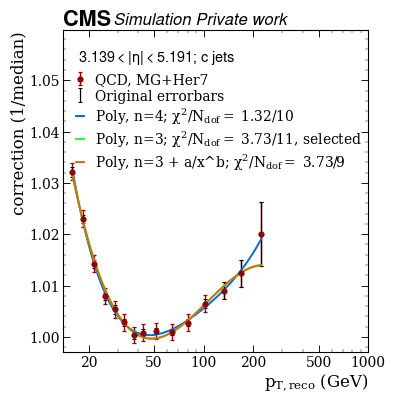

Read data from  out_txt/response_fit_results_L5_Herwig-TTBAR.json
Fitting subsample:  g Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0008947877737583709
Using the Poly, n=4 fit results 


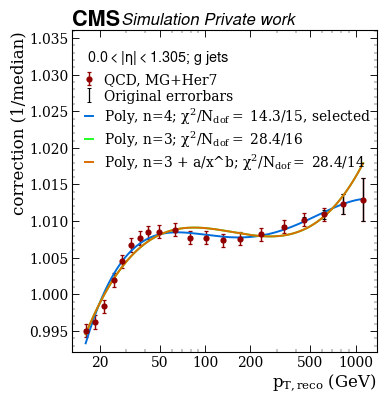

Fitting subsample:  g Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.0022631842709390617
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


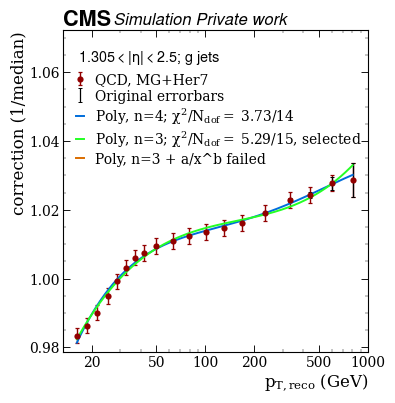

Fitting subsample:  g Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0014192168242624038
Using the Poly, n=4 fit results 


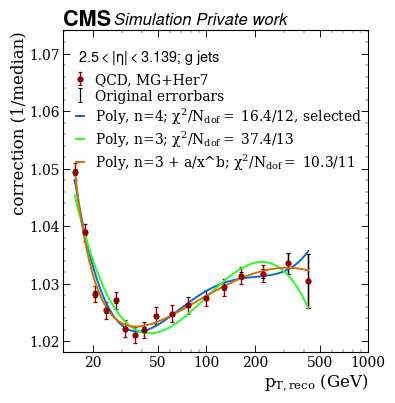

Fitting subsample:  g Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0011601116387559562
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


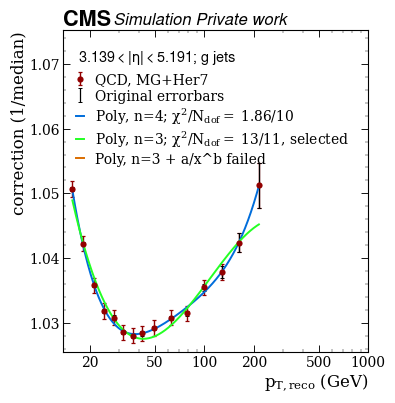

Read data from  out_txt/response_fit_results_L5_Herwig-TTBAR.json
Fitting subsample:  s Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.002364793009645705
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


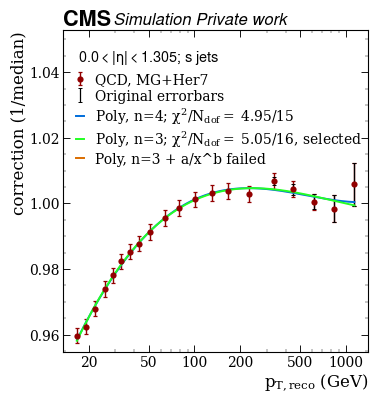

Fitting subsample:  s Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.0034870651797769994
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


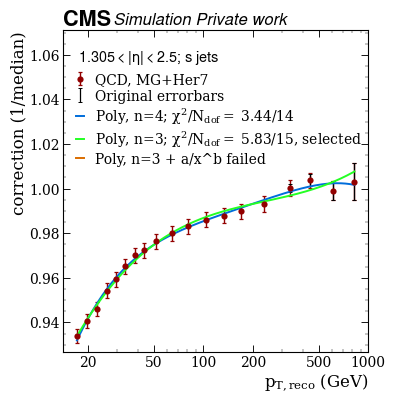

Fitting subsample:  s Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0026589432228942556
Using the Poly, n=3 fit results 


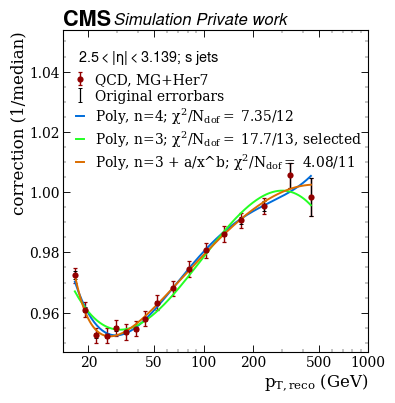

Fitting subsample:  s Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0015355311459698652
Using the Poly, n=3 fit results 


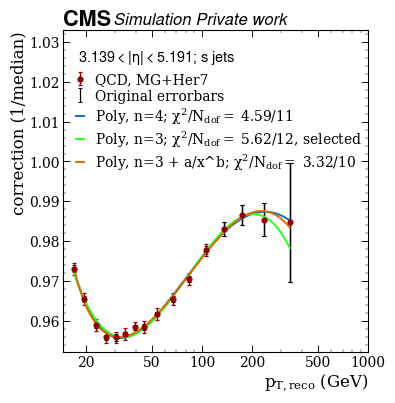

Read data from  out_txt/response_fit_results_L5_Herwig-TTBAR.json
Fitting subsample:  ud Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0032005827500271866
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


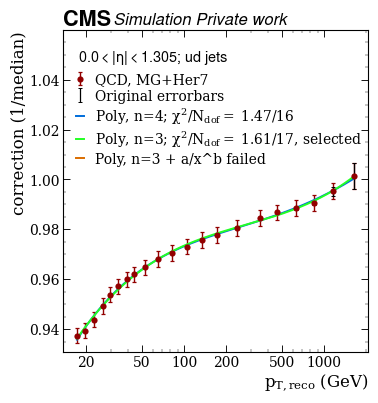

Fitting subsample:  ud Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.004209499239552339
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


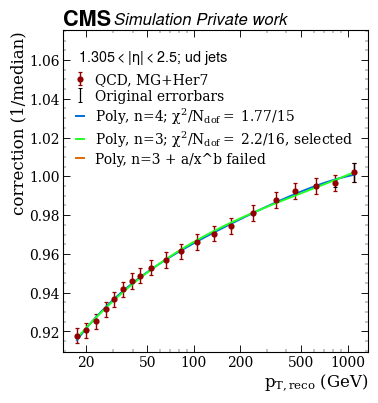

Fitting subsample:  ud Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0033106817675607747
Using the Poly, n=4 fit results 


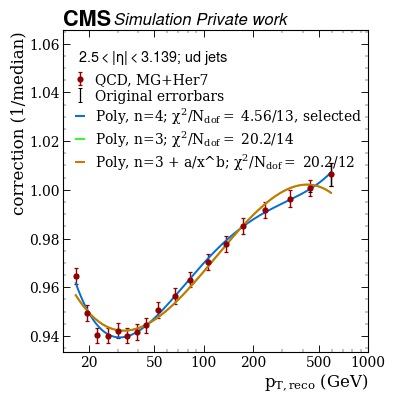

Fitting subsample:  ud Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0010128175692640073
Using the Poly, n=4 fit results 


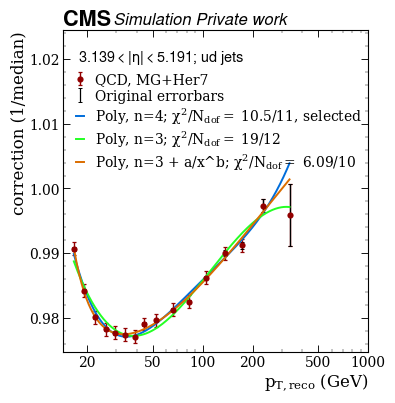

Read data from  out_txt/response_fit_results_L5_Herwig-TTBAR.json
Fitting subsample:  q Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.002850908496086319
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


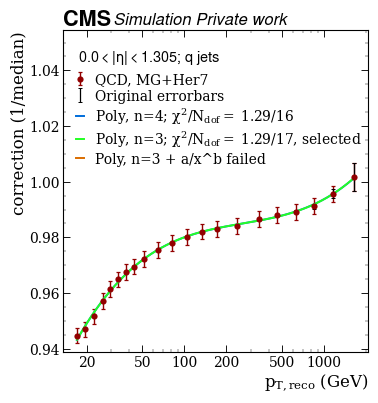

Fitting subsample:  q Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.004005778910278079
Using the Poly, n=3 fit results 


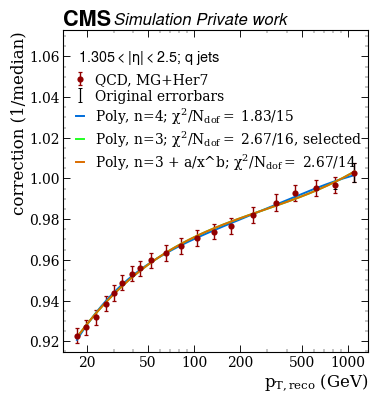

Fitting subsample:  q Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.00322154013824893
Using the Poly, n=4 fit results 


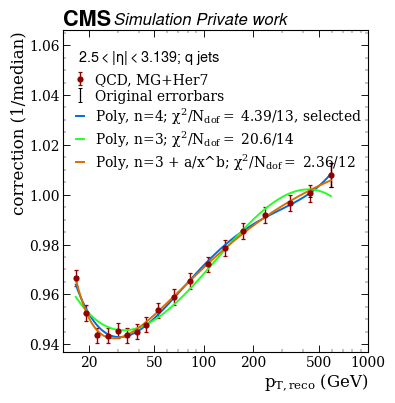

Fitting subsample:  q Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.001085207532389132
Using the Poly, n=3 fit results 


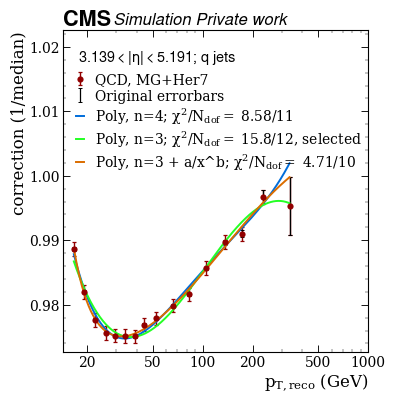

Read data from  out_txt/response_fit_results_L5_Herwig-TTBAR.json
Fitting subsample:  u Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0031654499424598526
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


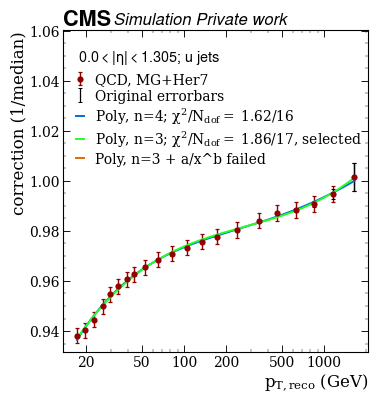

Fitting subsample:  u Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.004074205602654463
Using the Poly, n=3 fit results 


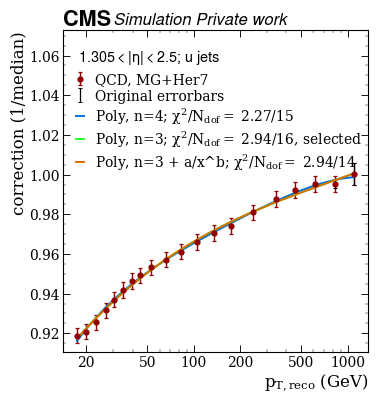

Fitting subsample:  u Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.003276115695731563
Using the Poly, n=3 fit results 


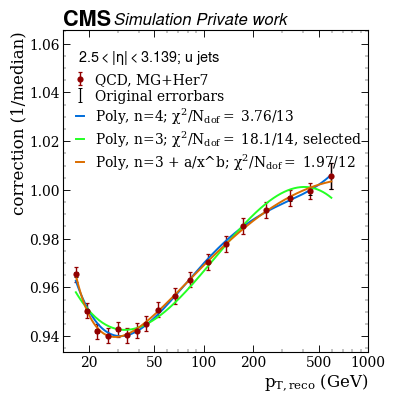

Fitting subsample:  u Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0009638967642792706
Using the Poly, n=4 fit results 


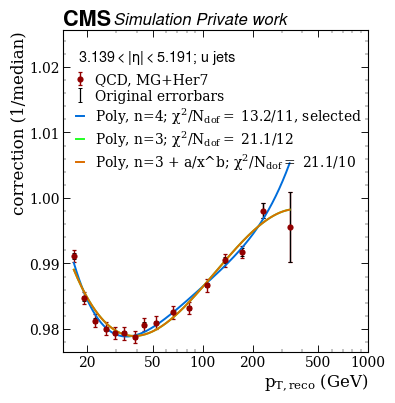

Read data from  out_txt/response_fit_results_L5_Herwig-TTBAR.json
Fitting subsample:  d Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0032316866796999913
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


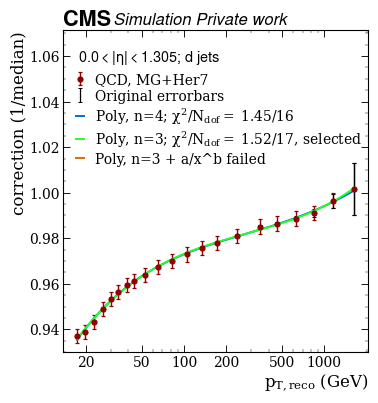

Fitting subsample:  d Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.0046429120792923165
Using the Poly, n=3 fit results 


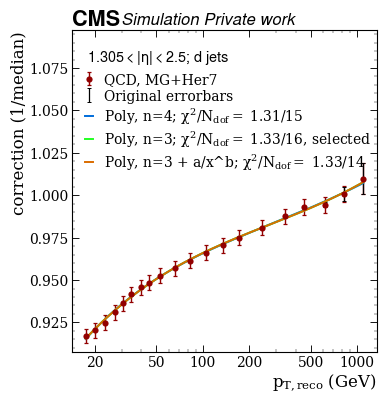

Fitting subsample:  d Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0034684220225101206
Using the Poly, n=4 fit results 


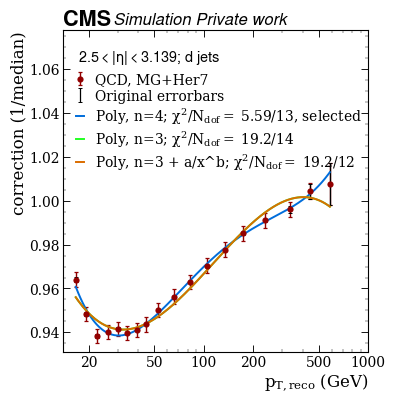

Fitting subsample:  d Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.001179835790850109
Using the Poly, n=3 fit results 


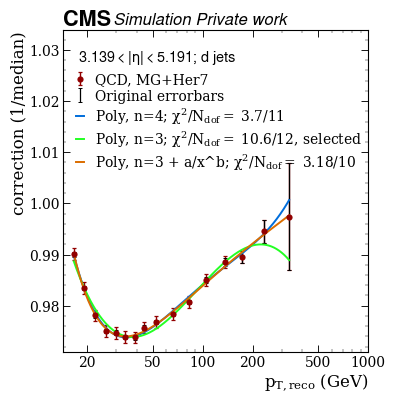

Read data from  out_txt/response_fit_results_L5_Herwig-TTBAR.json
Fitting subsample:  all Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.001376320056785907
Using the Poly, n=3 fit results 


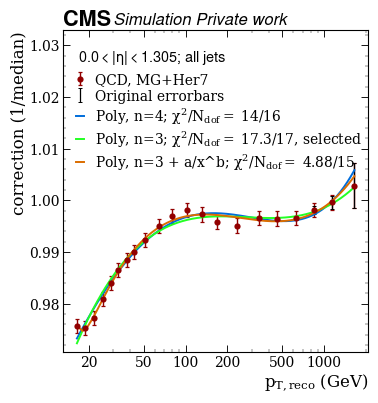

Fitting subsample:  all Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.0023206269384268507
Using the Poly, n=3 fit results 


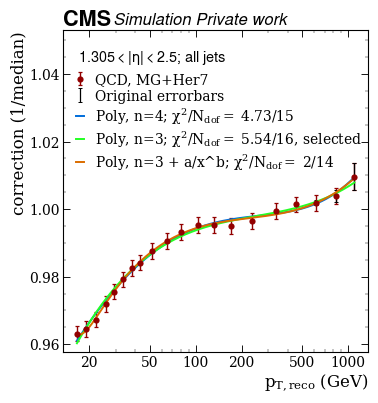

Fitting subsample:  all Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0017344356402440699
Using the Poly, n=4 fit results 


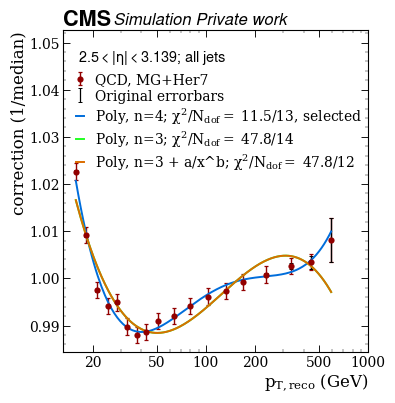

Fitting subsample:  all Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0013630713461568744
Using the Poly, n=3 fit results 


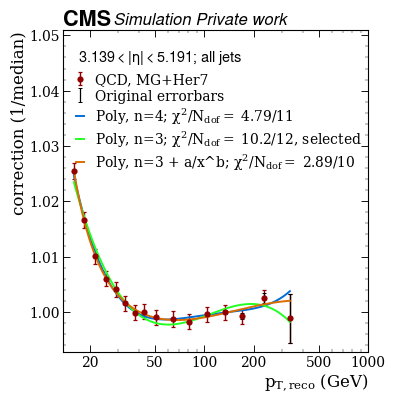

Read data from  out_txt/response_fit_results_L5_DY-MG-Py.json
Fitting subsample:  b Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.000905499393127307
Using the Poly, n=4 fit results 


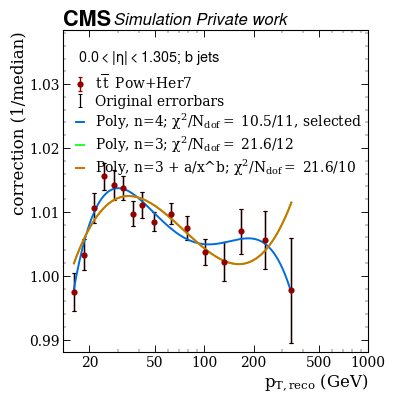

Fitting subsample:  b Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.0012123316581043988
Using the Poly, n=3 fit results 


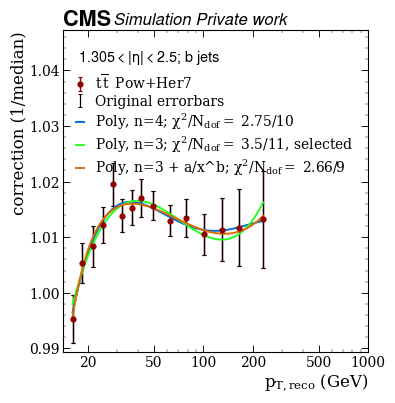

Fitting subsample:  b Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0026819032120124044
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


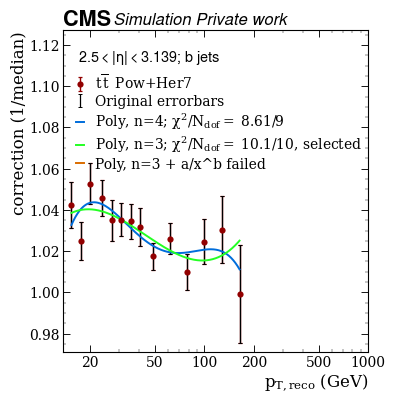

Fitting subsample:  b Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.003023778611233907
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


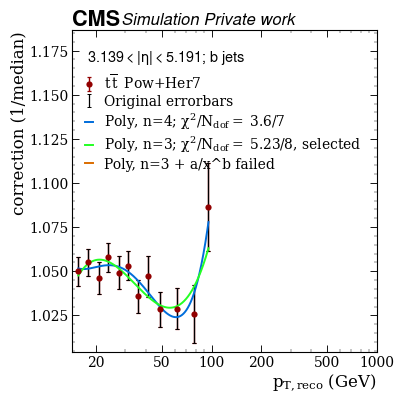

Read data from  out_txt/response_fit_results_L5_DY-MG-Py.json
Fitting subsample:  c Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0008246286266885895
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


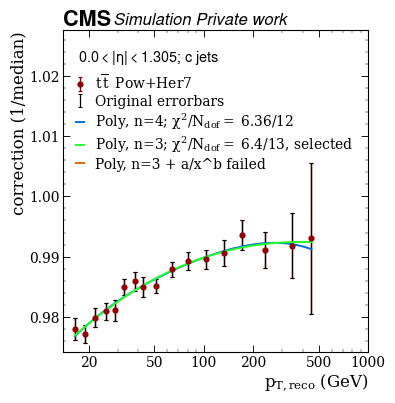

Fitting subsample:  c Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.002081728224516394
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


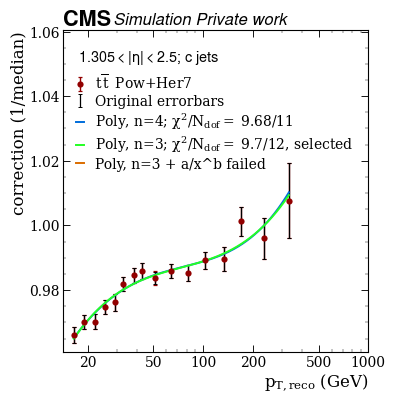

Fitting subsample:  c Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0017549517840831253
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


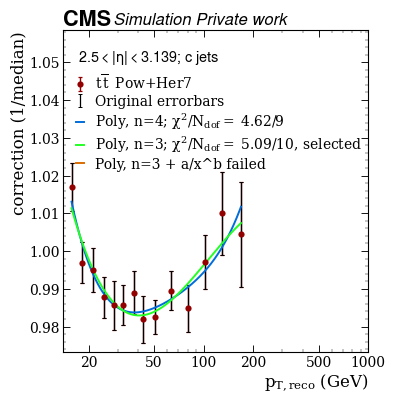

Fitting subsample:  c Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.001643953993629882
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


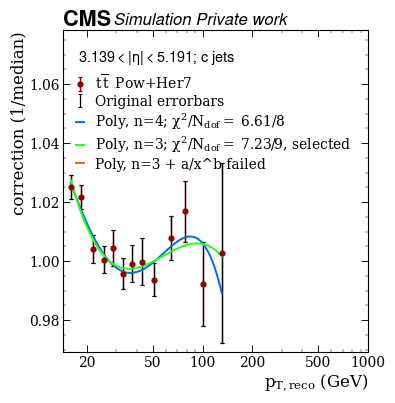

Read data from  out_txt/response_fit_results_L5_DY-MG-Py.json
Fitting subsample:  g Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0009245397270532919
Poly, n=3 + a/x^b fit failed
Using the Poly, n=4 fit results 


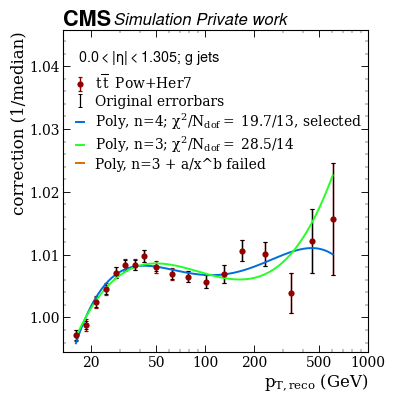

Fitting subsample:  g Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.0023774160864063146
Using the Poly, n=3 fit results 


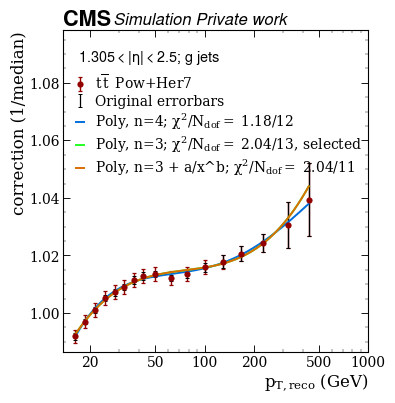

Fitting subsample:  g Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0014365155158055144
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


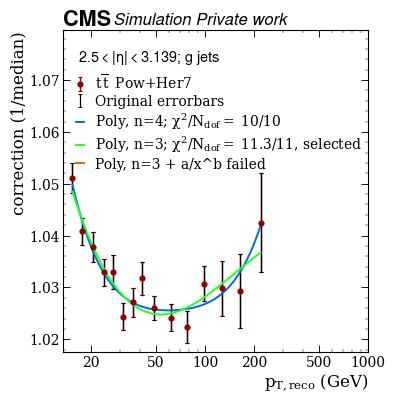

Fitting subsample:  g Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0010554568994604607
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


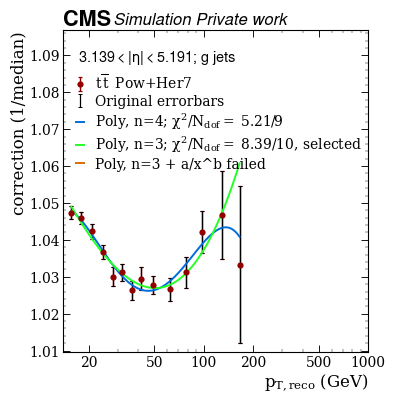

Read data from  out_txt/response_fit_results_L5_DY-MG-Py.json
Fitting subsample:  s Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0019106446697616077
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


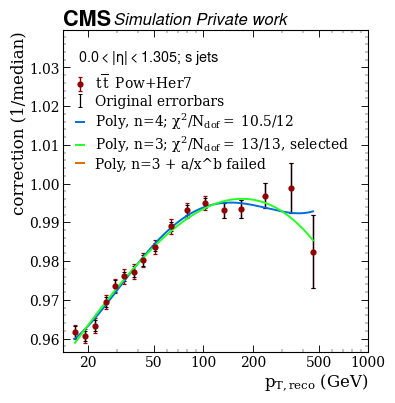

Fitting subsample:  s Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.003503309286678913
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


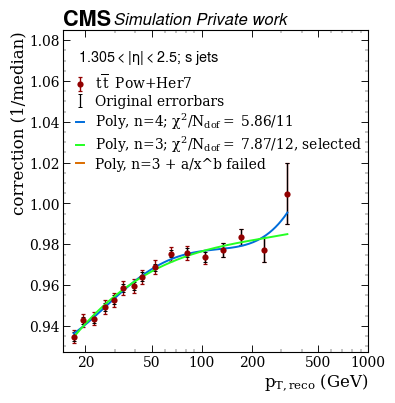

Fitting subsample:  s Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0021767078883751624
Using the Poly, n=3 fit results 


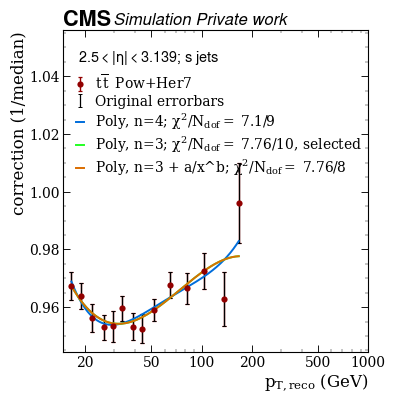

Fitting subsample:  s Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0013477561913030458
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


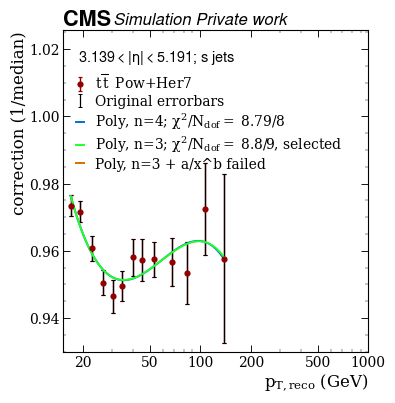

Read data from  out_txt/response_fit_results_L5_DY-MG-Py.json
Fitting subsample:  ud Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.002385855275839155
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


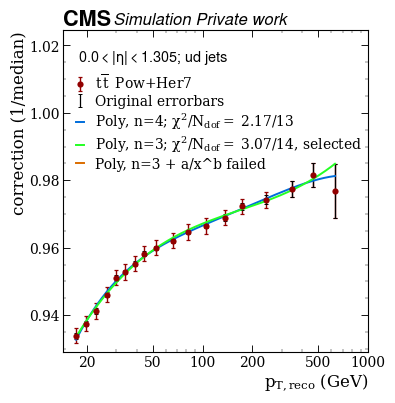

Fitting subsample:  ud Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.0036152830664044735
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


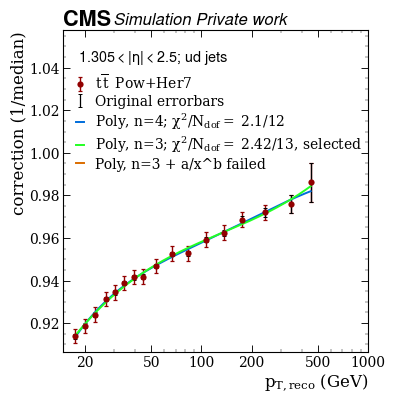

Fitting subsample:  ud Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0022174338042175003
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


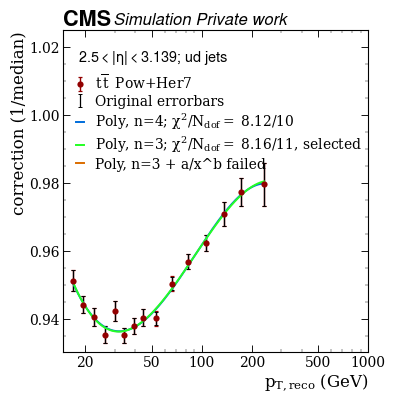

Fitting subsample:  ud Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0016612297059588111
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


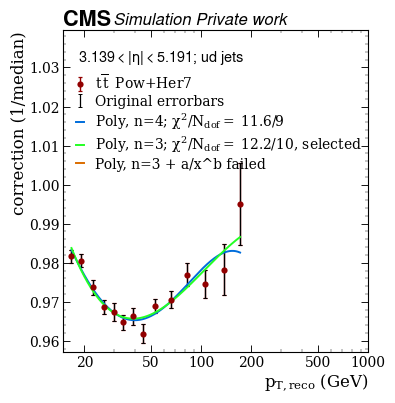

Read data from  out_txt/response_fit_results_L5_DY-MG-Py.json
Fitting subsample:  q Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0020317248489277796
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


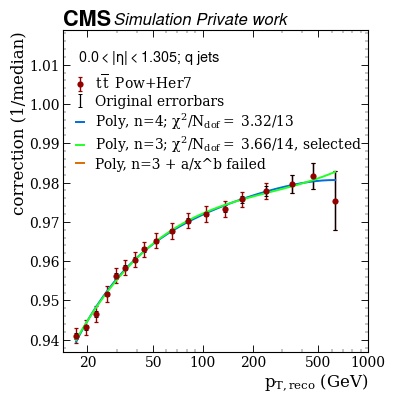

Fitting subsample:  q Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.003396158047388409
Using the Poly, n=3 fit results 


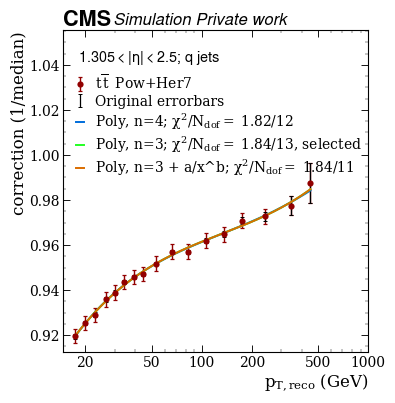

Fitting subsample:  q Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.002124350877284381
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


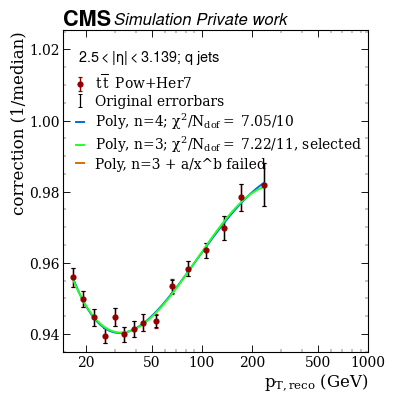

Fitting subsample:  q Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0014812329452708662
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


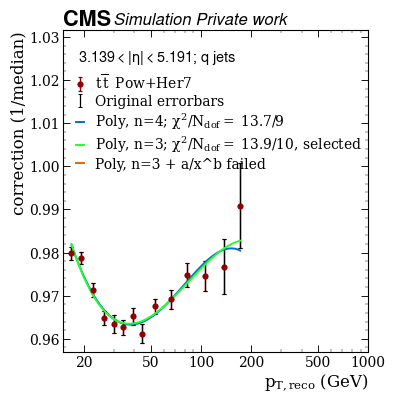

Read data from  out_txt/response_fit_results_L5_DY-MG-Py.json
Fitting subsample:  u Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0026869958375697056
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


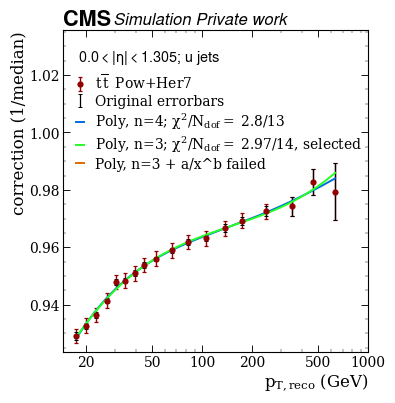

Fitting subsample:  u Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.003353124960250642
Using the Poly, n=3 fit results 


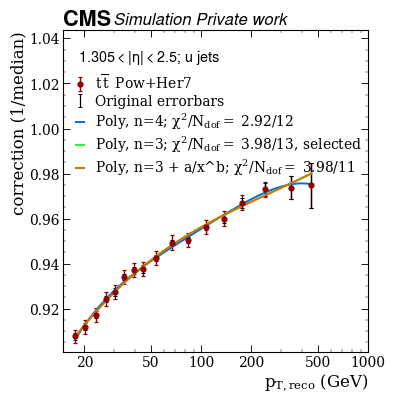

Fitting subsample:  u Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0023790964753374667
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


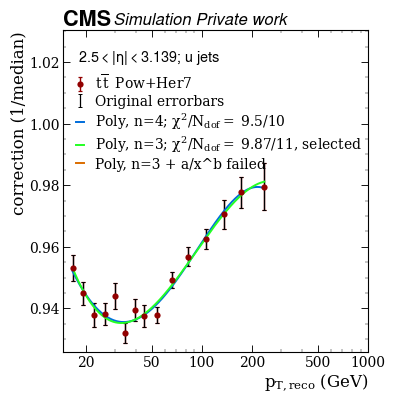

Fitting subsample:  u Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0023711852237455924
Using the Poly, n=4 fit results 


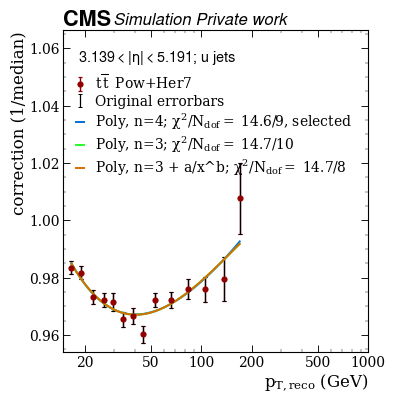

Read data from  out_txt/response_fit_results_L5_DY-MG-Py.json
Fitting subsample:  d Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0021222398137832723
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


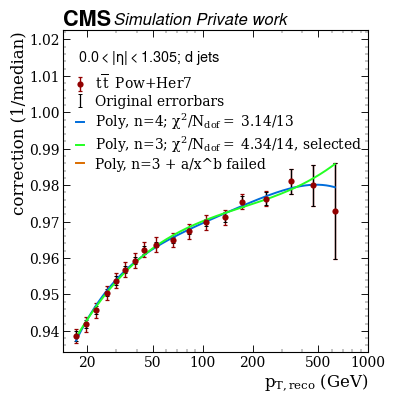

Fitting subsample:  d Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.003908259850150081
Using the Poly, n=3 fit results 


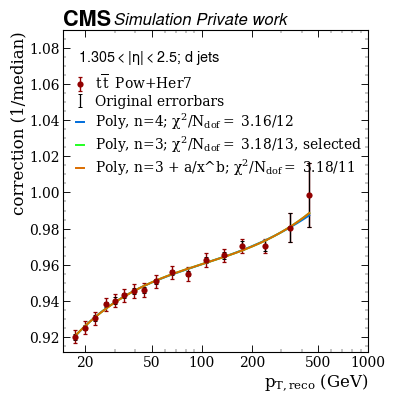

Fitting subsample:  d Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.002325148201618155
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


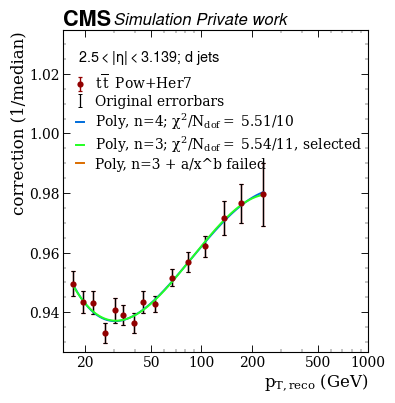

Fitting subsample:  d Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.000860114431411907
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


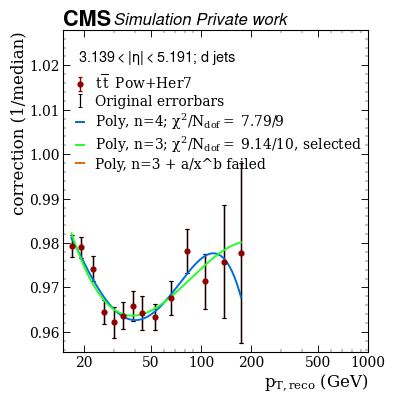

Read data from  out_txt/response_fit_results_L5_DY-MG-Py.json
Fitting subsample:  all Eta idx = 0, eta bin = [0.0; 1.305 ]
men_rel_uncert_tmp: 0.0014201861823116724
Using the Poly, n=3 fit results 


/cvmfs/sft.cern.ch/lcg/views/LCG_104/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:504: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


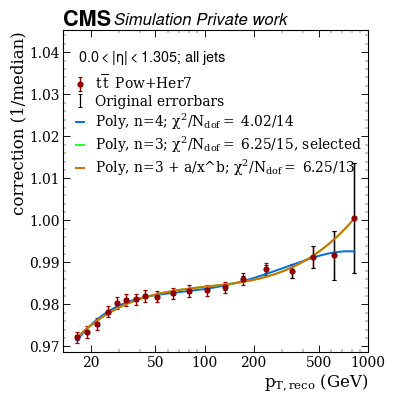

Fitting subsample:  all Eta idx = 1, eta bin = [1.305; 2.5 ]
men_rel_uncert_tmp: 0.002297546738247902
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


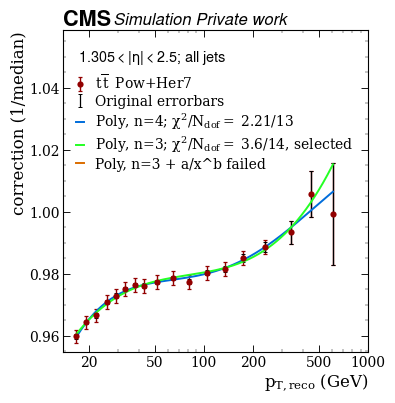

Fitting subsample:  all Eta idx = 2, eta bin = [2.5; 3.139 ]
men_rel_uncert_tmp: 0.0019158863200991862
Using the Poly, n=3 fit results 


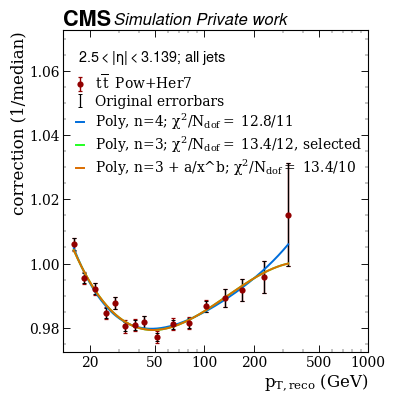

Fitting subsample:  all Eta idx = 3, eta bin = [3.139; 5.191 ]
men_rel_uncert_tmp: 0.0012674289570166143
Poly, n=3 + a/x^b fit failed
Using the Poly, n=3 fit results 


In [ ]:
fit_res_all_tags = do_fits(tags, names, flavors) #:-1 to exclude DY
fit_res_all_tags['simfit'] = do_fits_simfit(tags_simfit, names_simfit, colors, flavors)
fit_res_all_tags['Mikko'] = do_fits_simfit_Mikko(tags_simfitMikko, names_simfit+["merged"], colors=None, flavors=flavors)

In [92]:
%debug

> /afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/correction_fitter_helpers.py(556)fit_corrections()
    554     for yval, std, reco_pt, std_orig, data_tag in zip(yvals, stds, xvals, stds_orig, data_tags):
    555         if colors is not None:
--> 556             color = colors[data_tag]
    557         else:
    558             color = next(ax._get_lines.prop_cycler)['color']

ipdb> colors
{'QCD, MG+Py8': '#b6dbff', '$t\\overline{\\, t\\!}$  Pow+Py8': '#b66dff'}
ipdb> q


In [81]:
fit_res_all_tags

{'_L5_QCD-MG-Py': {'bJ': array([[ 0.00000000e+00,  1.30500000e+00,  6.00000000e+00,
           1.56887239e+01,  2.61373972e+03,  4.65086663e-01,
           1.12102400e+00, -8.00762667e-01,  2.40418993e-01,
          -2.59369003e-02,  0.00000000e+00],
         [ 1.30500000e+00,  2.50000000e+00,  6.00000000e+00,
           1.56987158e+01,  1.58337894e+03, -1.17199632e-01,
           2.29029400e+00, -1.66418670e+00,  5.19749043e-01,
          -5.90825132e-02,  0.00000000e+00],
         [ 2.50000000e+00,  3.13900000e+00,  6.00000000e+00,
           1.57394808e+01,  5.87228438e+02,  2.19770044e-01,
           1.84489326e+00, -1.54669941e+00,  5.61660596e-01,
          -7.44881559e-02,  0.00000000e+00],
         [ 3.13900000e+00,  5.19100000e+00,  6.00000000e+00,
           1.57861504e+01,  3.12004978e+02, -9.60009951e-01,
           4.90739791e+00, -4.38936566e+00,  1.69313342e+00,
          -2.37708128e-01,  0.00000000e+00]]),
  'cJ': array([[ 0.00000000e+00,  1.30500000e+00,  6.00000000e+

In [ ]:
# fit_res_all_tags['Mikko']['aM']

In [ ]:
# %debug

In [ ]:
# from correction_fitter_helpers import *
# a = Mikkofun_ud.replace(f'[{2}]', f'[{2+5}]')
# Mikkofun_ud
# a

In [ ]:
# def save_correction_txt_file_Mikko(txtfile_outname, fit_res_all_tags):
#     '''
#     Saves the corrections in the txt file with the name `txtfile_outname`.
#     fit_res_all_tags: for each correction tag (e.g., T and J), a dictionary of corrections for each flavor
#     '''
#     with open(txtfile_outname, 'w') as file:
#         # str_poly='([0]+[1]*log10(x)+[2]*pow(log10(x),2)+[3]*pow(log10(x),3)+[4]*1/pow(log10(x),[5]))'
#         str_poly='([0]+[1]*log10(x)+[2]*pow(log10(x),2)+[3]*pow(log10(x),3)+[4]*pow(log10(x),4))'
#         file.write(header_txt+'\n')
#         for tag in fit_res_all_tags:
#             fit_res_all = fit_res_all_tags[tag]
#             for key in fit_res_all.keys():
#                 fit_res = fit_res_all[key]
#                 file.write(f'[{key}]\n')
# #                 n_add_parm = 2 #+2 because of the pt lower/higher limits that are not accounted into the # parameters before
#                 if 'sM' in key:
#                     fun_tmp = Mikkofun_ud
#                     for ii in range(6,-1,-1):
#                         fun_tmp = fun_tmp.replace(f'[{ii}]', f'[{ii+5}]')
#                     fun_str = f'({fun_tmp})/({Mikkofun_s})'
# #                     n_add_parm+=6
#                 elif 'udM' in key:
#                     fun_str = f'1/({Mikkofun_ud})'
#                 elif 'M' in key:
#                     fun_tmp = Mikkofun_ud
#                     for ii in range(6,-1,-1):
#                         fun_tmp = fun_tmp.replace(f'[{ii}]', f'[{ii+4}]')
#                     fun_str = f'({fun_tmp})/({Mikkofun})'
# #                     n_add_parm+=6
#                 else:
#                     fun_str = str_poly
#                 file.write('{1 JetEta 1 JetPt '+fun_str+' Correction L5Flavor}\n')
#                 ### copy from the positive eta region into the negative
#                 fit_res = np.vstack([np.hstack([np.flip(fit_res[:,0:2]*-1), np.flip(fit_res[:,2:], 0)]), fit_res])
#                 for row in fit_res:
#                     row[2] = row[2]+2  #+2 because of the pt lower/higher limits that are not accounted into the # parameters before
#                     line2write = ('{:>11} '*5+'{:>13} '*(int(row[2])-2)).format(*row[:2], int(row[2]), *np.round(row[3:], 7))+'\n'
#                     file.write(line2write);
#     print("Saving the corrections with the name = ", txtfile_outname)

In [32]:
# txtfile_outname = 'test.txt'
# fits.save_correction_txt_file_Mikko(txtfile_outname, fit_res_all_tags)
fits.save_correction_txt_file_Mikko(txtfile_outname, fit_res_all_tags)

Saving the corrections with the name =  Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MGQCD_HCalPart.txt


In [59]:
# if not combine_antiflavour:
#     flavors = ['bbar', 'b', 'c', 's', 'ud', 'q', 'cbar', 'sbar', 'udbar', 'qbar']
# else:
#     flavors = ['b', 'c', 'u', 'd', 'g', 's', 'ud', 'q', 'all']
# # flavors = ['b', 'c', 'g', 's', 'ud', 'all', 'unmatched']
# # flavors = ['c']
# ### Put the minimum limit on the relative uncertainty to min_rel_uncert
# # min_rel_uncert = 0.0005
# min_rel_uncert_relative = 0.05

# correction_for = 'Her' #'Py', 'Her' or 'standPy'

# unc_eta_str = '_'+eta_binning if eta_binning != "Summer20Flavor" else ''
# if correction_for == 'Py':
#     txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs{combine_antiflavour_txt+unc_eta_str}.txt'
#     tags, names = ['_L5_Pythia-TTBAR', '_L5_QCD-MG-Py'], [f"{ttbarlab} Pow+Py8", 'QCD, MG+Py8']
# elif correction_for == 'Her':
#     txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs{combine_antiflavour_txt}_Her{unc_eta_str}.txt'
#     tags, names = ['_L5_QCD-MG-Her', '_L5_Herwig-TTBAR'], ['QCD, MG+Her7', f"{ttbarlab} Pow+Her7"]
# elif correction_for == 'standPy':
#     txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePy{combine_antiflavour_txt}QCD{unc_eta_str}.txt'
#     tags, names = ['_L5_QCD-Py', '_L5_Pythia-TTBAR'], ['QCD, Py8', f"{ttbarlab} Pow+Py8"]
# else:
#     raise ValueError("Please provide correction_for from ['Py', 'Her' or 'standPy']")
# tags = [tag+eta_binning_str+combine_antiflavour_txt for tag in tags]

# closure = read_data("Median", "all", '_L5_QCD-Py'+eta_binning_str)

# fit_res_all_tags = {}
# for data_tag, data_name in np.transpose([tags, names]):
#     fit_res_all = {}
    
#     for flav in ['b']:
#         fit_res = []
#         ## if fit flavor-antiflavor, closure by the L5 correction
#         if not combine_antiflavour:
#             flav2 = flav[:-3] if 'bar' in flav else flav
#             closure = read_data("Median", flav2, data_tag[:-len(combine_antiflavour_txt)])
#         data = {data_tag: read_data4plot(flav, data_tag, closure )}

#         for etaidx in range(jeteta_bins.nbins):
#             print('Fitting subsample: ', flav, f'Eta idx = {etaidx}, eta bin = [{jeteta_bins.edges[etaidx]}; {jeteta_bins.edges[etaidx+1]} ]', )
#             fit_res_new = fits.fit_corrections(etaidx, data, flav=flav, data_tags=[data_name],
#                                                  fits2plot=fits2plot, main_fit="Poly, n=3",
#                               figdir2=figdir,
#                               jeteta_bins=jeteta_bins, pt_bins=pt_bins,
#                               plot_initial_val=False,
#                               use_recopt=True,
#                               maxlimit_static_pnt=True,
# #                               max_ptval=4000,
#                               min_rel_uncert_relative=min_rel_uncert_relative,
#                               show_original_errorbars=True,
#                               saveplots=False,)
            
#             fit_res = np.concatenate([fit_res, fit_res_new])

#         num = int(5 + fit_res[2])
#         fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
#         correction_name = my_mapping(flav)
#         correction_name += 'T' if 'TTBAR' in data_tag else 'J' 
#         fit_res_all[correction_name] = fit_res
#     fit_res_all_tags[data_tag] = fit_res_all

# 'a';

In [ ]:
# with open(txtfile_outname, 'w') as file:
#     file.write(header_txt+'\n')
#     for tag in fit_res_all_tags:
#         fit_res_all = fit_res_all_tags[tag]
#         for key in fit_res_all.keys():
#             fit_res = fit_res_all[key]
#             file.write(f'[{key}]\n')
#             file.write('{1 JetEta 1 JetPt ([0]+[1]*log10(x)+[2]*pow(log10(x),2)+[3]*pow(log10(x),3)+[4]*pow(log10(x),4)) Correction L5Flavor}\n')
#             ### copy from the positive eta region into the negative
#             fit_res = np.vstack([np.hstack([np.flip(fit_res[:,0:2]*-1), np.flip(fit_res[:,2:], 0)]), fit_res])
#             for row in fit_res:
#                 row[2] = row[2]+2  #+2 because of the pt lower/higher limits that are not accounted into the # parameters before
#                 line2write = ('{:>11} '*5+'{:>13} '*(int(row[2])-2)).format(*row[:2], int(row[2]), *np.round(row[3:], 7))+'\n'
#                 file.write(line2write);

                
# print("Saving the corrections with the name = ", txtfile_outname)

In [ ]:
# # txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePyQCD{eta_binning_str}.txt'
# with open(txtfile_outname, 'w') as file:
#     file.write(header_txt+'\n')
#     for tag in fit_res_all_tags:
#         fit_res_all = fit_res_all_tags[tag]
#         for key in fit_res_all.keys():
#             fit_res = fit_res_all[key]
#             file.write(f'[{key}]\n')
#             file.write('{1 JetEta 1 JetPt ([0]+[1]*log10(x)+[2]*pow(log10(x),2)+[3]*pow(log10(x),3)+[4]*pow(log10(x),4)) Correction L5Flavor}\n')
#             ### copy from the positive eta region into the negative
#             fit_res = np.vstack([np.hstack([np.flip(fit_res[:,0:2]*-1), np.flip(fit_res[:,2:], 0)]), fit_res])
#             for row in fit_res:
#                 row[2] = row[2]+2  #+2 because of the pt lower/higher limits that are not accounted into the # parameters before
#                 line2write = ('{:>11} '*5+'{:>13} '*(int(row[2])-2)).format(*row[:2], int(row[2]), *np.round(row[3:], 7))+'\n'
#                 file.write(line2write);

                

# 4; ## to suppress printouts of write

### Combined fit

Fitting flavor:  b Eta idx = 0, eta bin = [0.0; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta0p0to1p305.pdf / .png


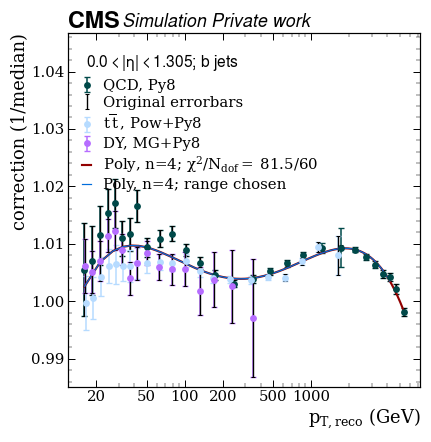

Fitting flavor:  b Eta idx = 1, eta bin = [1.305; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta1p305to2p5.pdf / .png


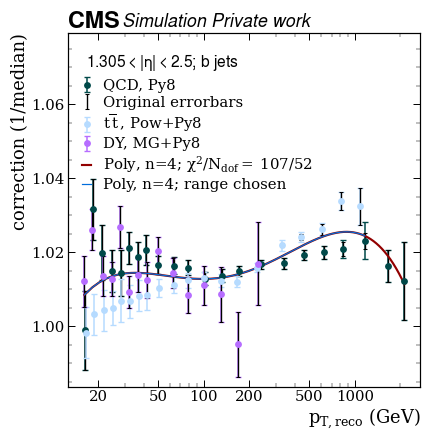

Fitting flavor:  b Eta idx = 2, eta bin = [2.5; 3.139 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta2p5to3p139.pdf / .png


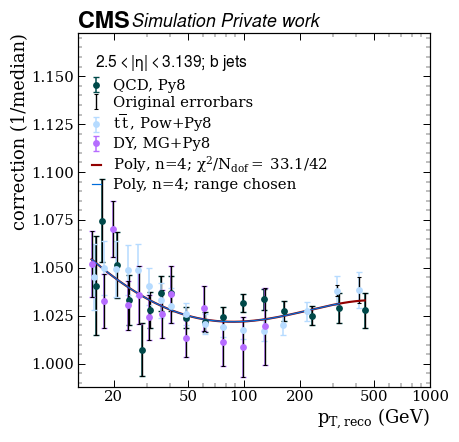

Fitting flavor:  b Eta idx = 3, eta bin = [3.139; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_b_eta3p139to5p191.pdf / .png


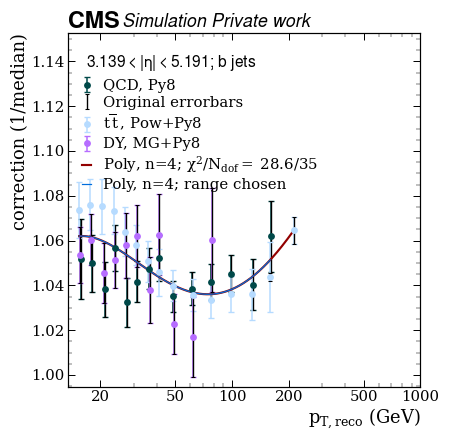

Fitting flavor:  c Eta idx = 0, eta bin = [0.0; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta0p0to1p305.pdf / .png


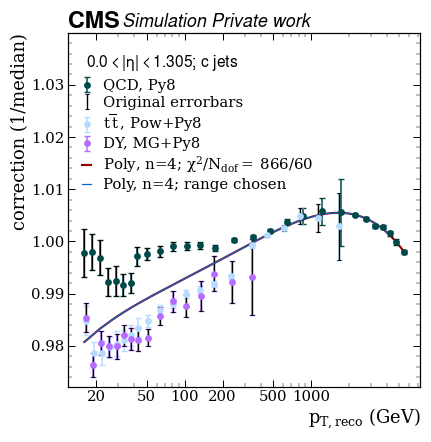

Fitting flavor:  c Eta idx = 1, eta bin = [1.305; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta1p305to2p5.pdf / .png


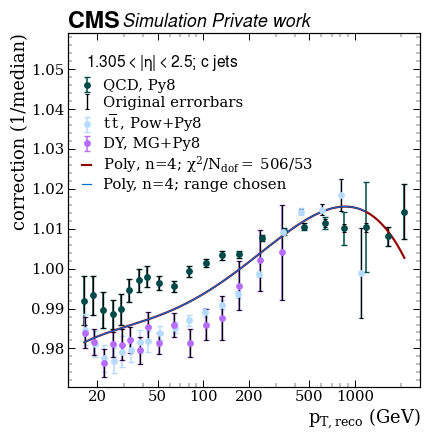

Fitting flavor:  c Eta idx = 2, eta bin = [2.5; 3.139 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta2p5to3p139.pdf / .png


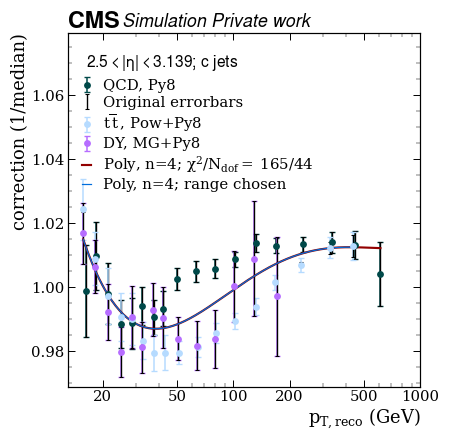

Fitting flavor:  c Eta idx = 3, eta bin = [3.139; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_c_eta3p139to5p191.pdf / .png


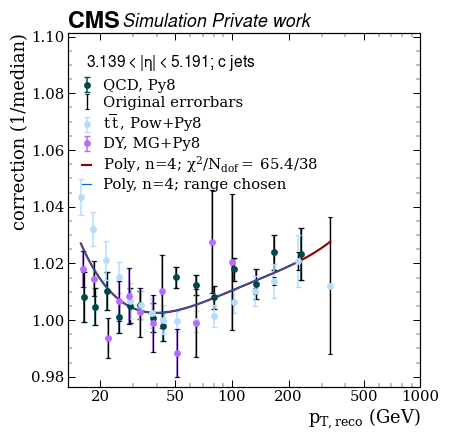

Fitting flavor:  g Eta idx = 0, eta bin = [0.0; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta0p0to1p305.pdf / .png


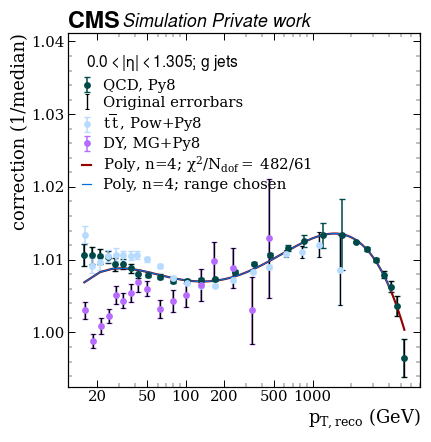

Fitting flavor:  g Eta idx = 1, eta bin = [1.305; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta1p305to2p5.pdf / .png


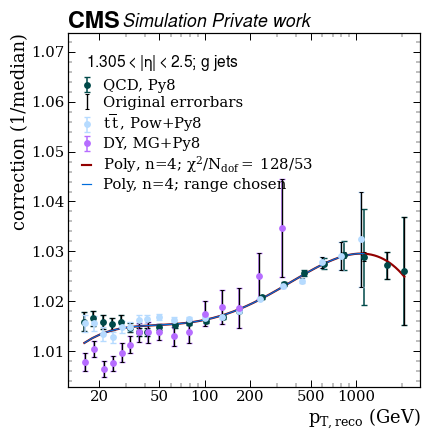

Fitting flavor:  g Eta idx = 2, eta bin = [2.5; 3.139 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta2p5to3p139.pdf / .png


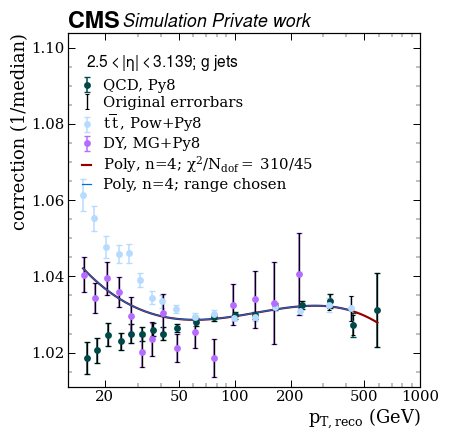

Fitting flavor:  g Eta idx = 3, eta bin = [3.139; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_g_eta3p139to5p191.pdf / .png


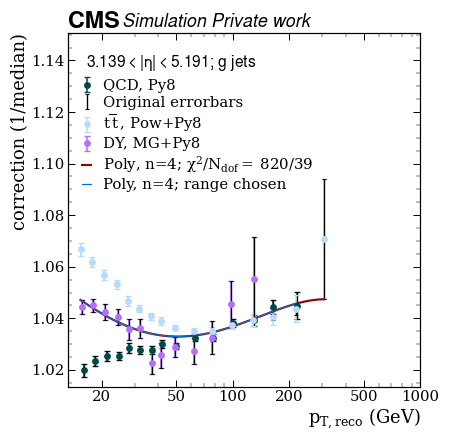

Fitting flavor:  s Eta idx = 0, eta bin = [0.0; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta0p0to1p305.pdf / .png


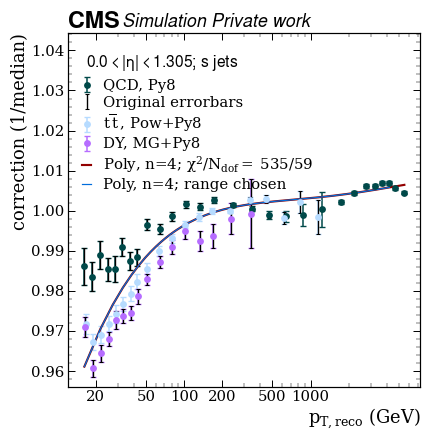

Fitting flavor:  s Eta idx = 1, eta bin = [1.305; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta1p305to2p5.pdf / .png


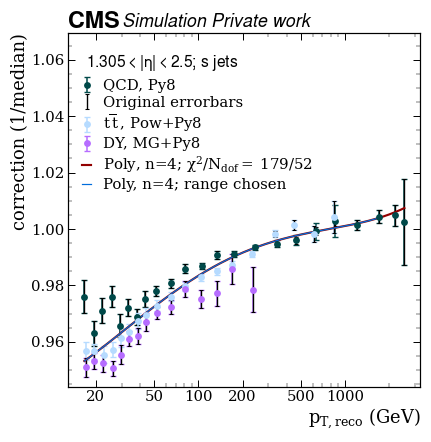

Fitting flavor:  s Eta idx = 2, eta bin = [2.5; 3.139 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta2p5to3p139.pdf / .png


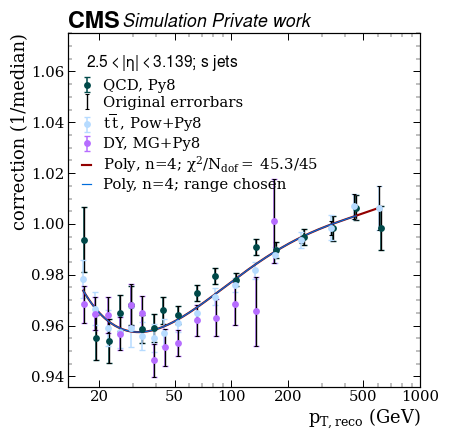

Fitting flavor:  s Eta idx = 3, eta bin = [3.139; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_s_eta3p139to5p191.pdf / .png


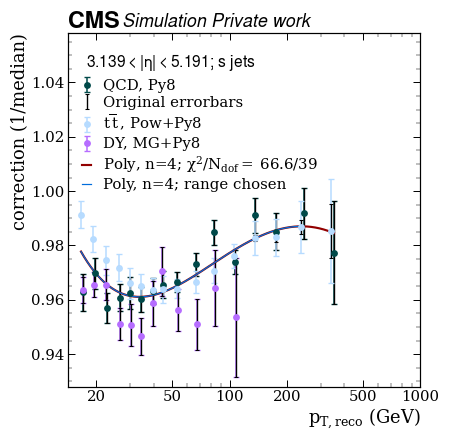

Fitting flavor:  ud Eta idx = 0, eta bin = [0.0; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta0p0to1p305.pdf / .png


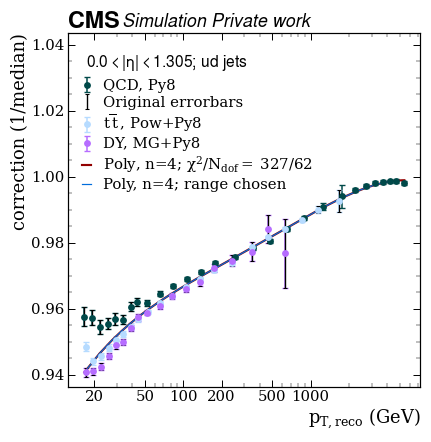

Fitting flavor:  ud Eta idx = 1, eta bin = [1.305; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta1p305to2p5.pdf / .png


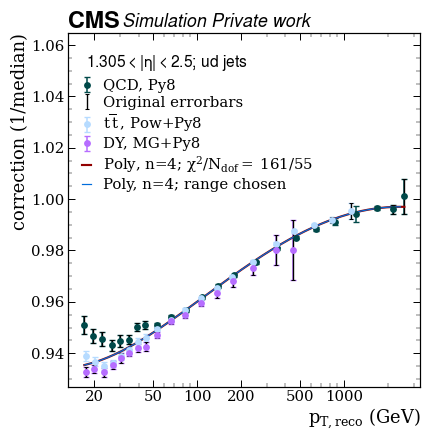

Fitting flavor:  ud Eta idx = 2, eta bin = [2.5; 3.139 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta2p5to3p139.pdf / .png


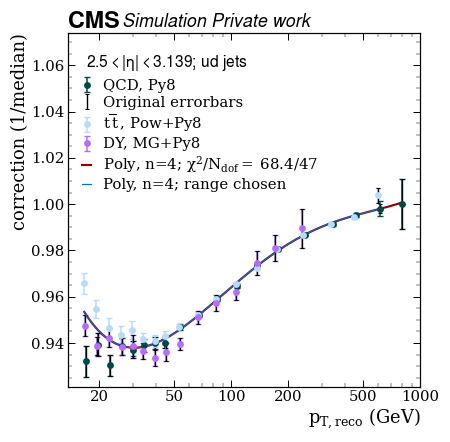

Fitting flavor:  ud Eta idx = 3, eta bin = [3.139; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_ud_eta3p139to5p191.pdf / .png


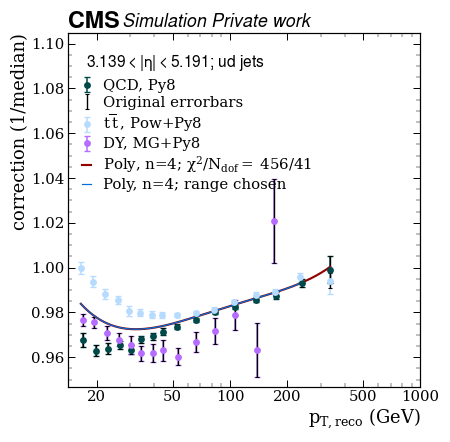

Fitting flavor:  q Eta idx = 0, eta bin = [0.0; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta0p0to1p305.pdf / .png


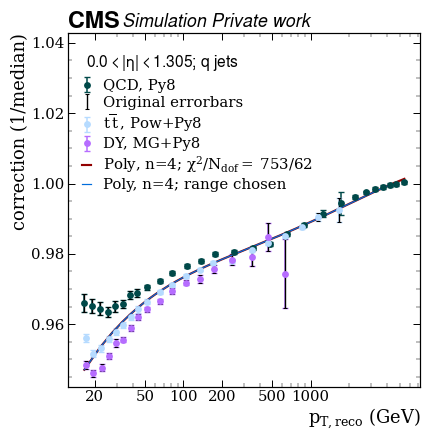

Fitting flavor:  q Eta idx = 1, eta bin = [1.305; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta1p305to2p5.pdf / .png


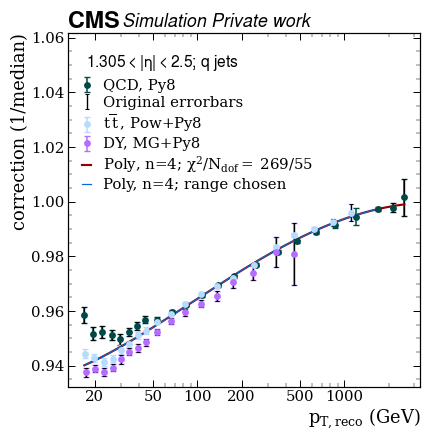

Fitting flavor:  q Eta idx = 2, eta bin = [2.5; 3.139 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta2p5to3p139.pdf / .png


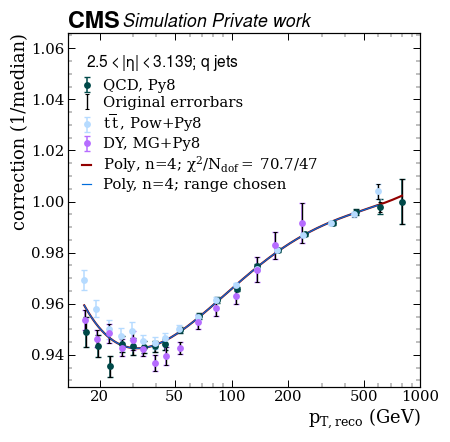

Fitting flavor:  q Eta idx = 3, eta bin = [3.139; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_q_eta3p139to5p191.pdf / .png


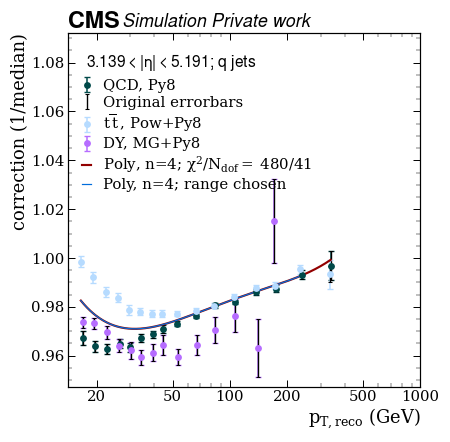

Fitting flavor:  u Eta idx = 0, eta bin = [0.0; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta0p0to1p305.pdf / .png


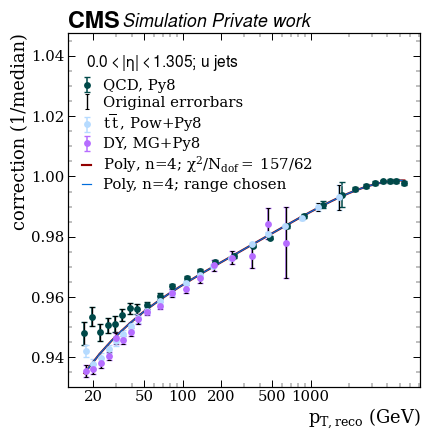

Fitting flavor:  u Eta idx = 1, eta bin = [1.305; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta1p305to2p5.pdf / .png


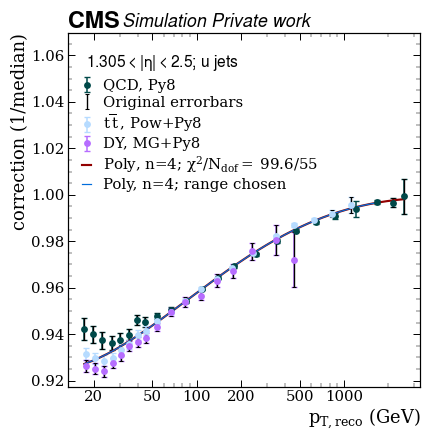

Fitting flavor:  u Eta idx = 2, eta bin = [2.5; 3.139 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta2p5to3p139.pdf / .png


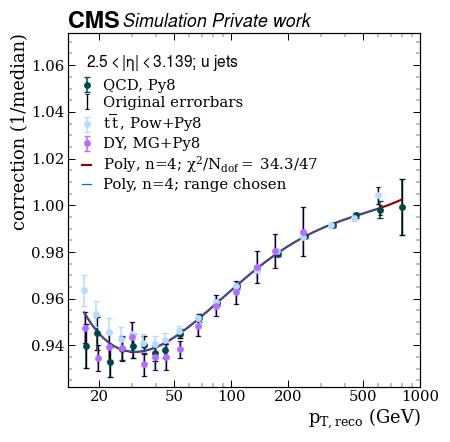

Fitting flavor:  u Eta idx = 3, eta bin = [3.139; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_u_eta3p139to5p191.pdf / .png


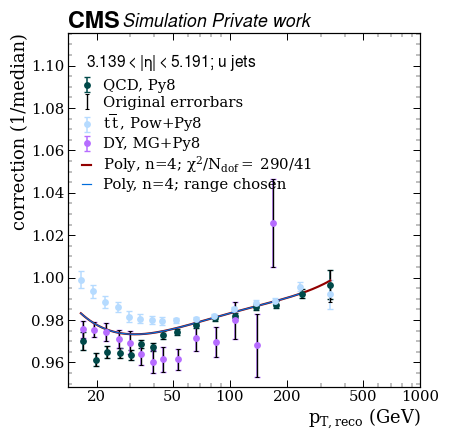

Fitting flavor:  d Eta idx = 0, eta bin = [0.0; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta0p0to1p305.pdf / .png


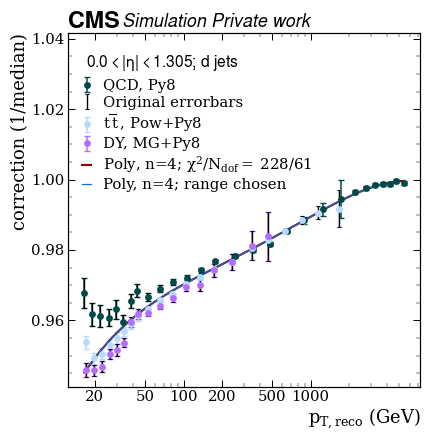

Fitting flavor:  d Eta idx = 1, eta bin = [1.305; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta1p305to2p5.pdf / .png


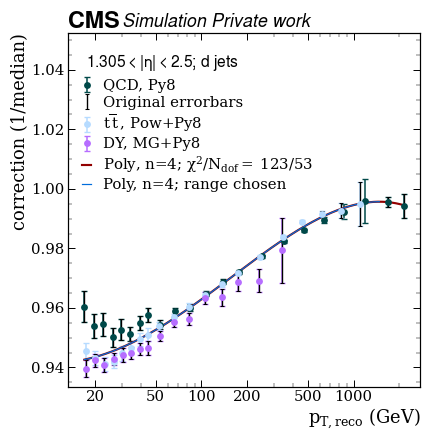

Fitting flavor:  d Eta idx = 2, eta bin = [2.5; 3.139 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta2p5to3p139.pdf / .png


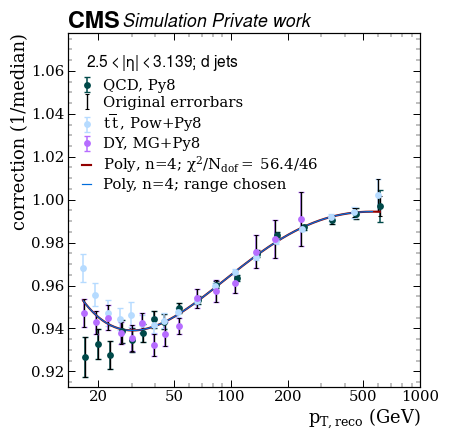

Fitting flavor:  d Eta idx = 3, eta bin = [3.139; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_d_eta3p139to5p191.pdf / .png


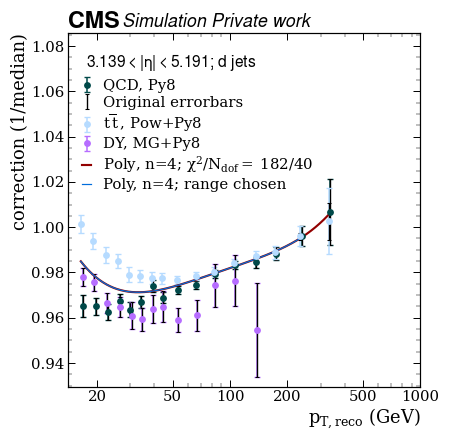

Fitting flavor:  unmatched Eta idx = 0, eta bin = [0.0; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta0p0to1p305.pdf / .png


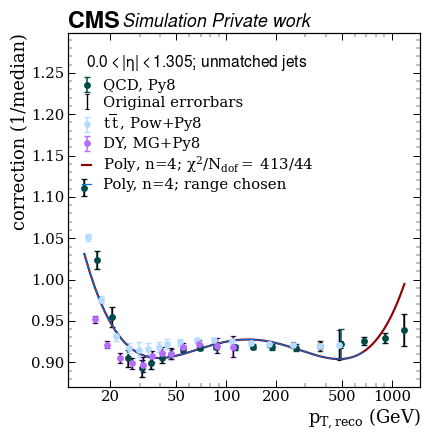

Fitting flavor:  unmatched Eta idx = 1, eta bin = [1.305; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta1p305to2p5.pdf / .png


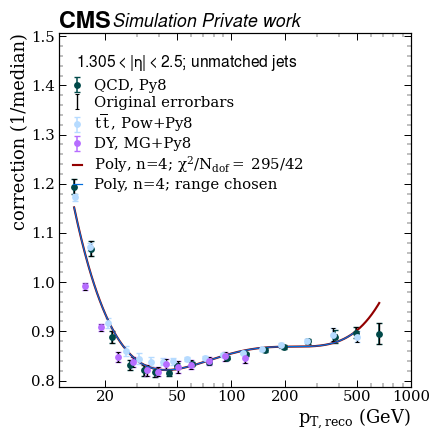

Fitting flavor:  unmatched Eta idx = 2, eta bin = [2.5; 3.139 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta2p5to3p139.pdf / .png


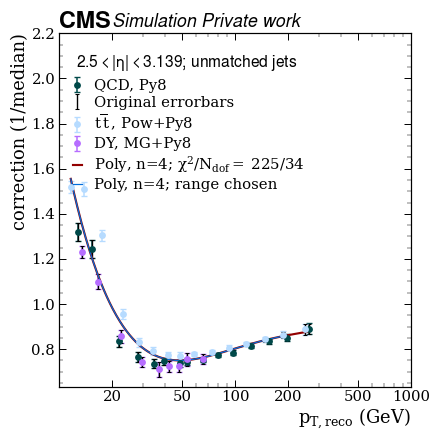

Fitting flavor:  unmatched Eta idx = 3, eta bin = [3.139; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_unmatched_eta3p139to5p191.pdf / .png


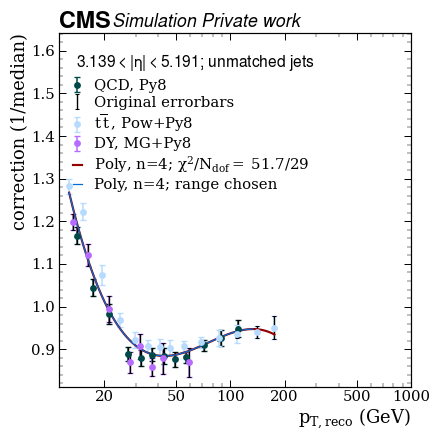

Fitting flavor:  all Eta idx = 0, eta bin = [0.0; 1.305 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_all_eta0p0to1p305.pdf / .png


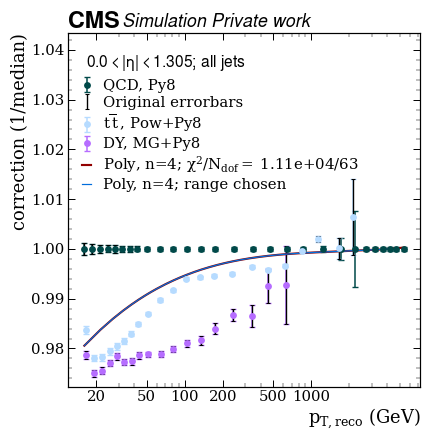

Fitting flavor:  all Eta idx = 1, eta bin = [1.305; 2.5 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_all_eta1p305to2p5.pdf / .png


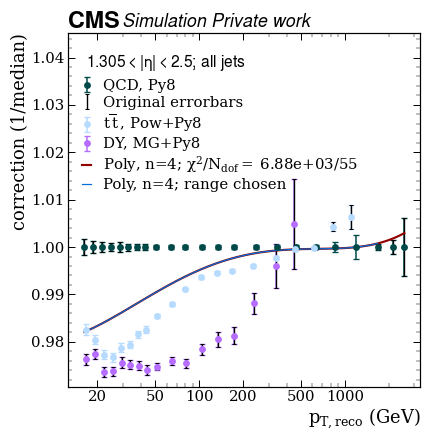

Fitting flavor:  all Eta idx = 2, eta bin = [2.5; 3.139 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_all_eta2p5to3p139.pdf / .png


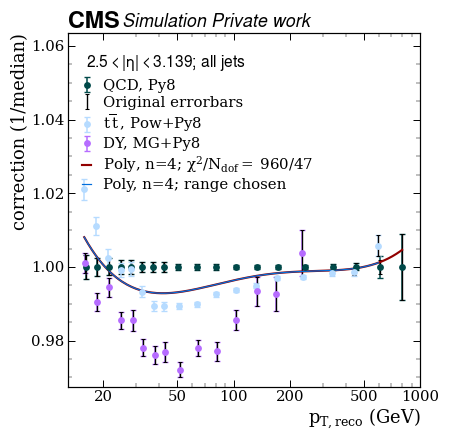

Fitting flavor:  all Eta idx = 3, eta bin = [3.139; 5.191 ]
Using the Poly, n=4 fit results 
Saving plot with the name =  fig/median_correction_fits/DY-MG_Py8/correction_fit_all_eta3p139to5p191.pdf / .png


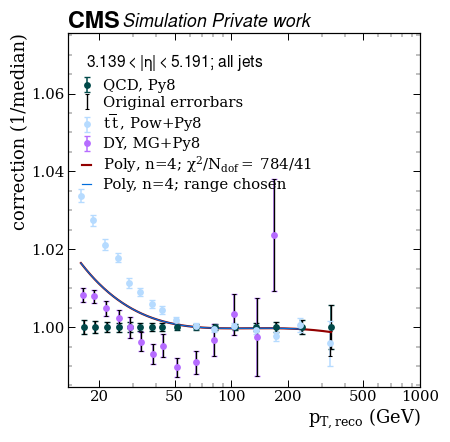

In [21]:
fits2plot = { ##name: [function, initial values, # parameters]
             "Poly, n=4": [fits.poly4, [ 1, 1, 1, 1, 1], 5],
#              "Poly, n=3": [fits.poly3, [ 1, 1, 1, 1], 4],
             }

if not combine_antiflavour:
    flavors = ['bbar', 'b', 'c', 's', 'ud', 'cbar', 'sbar', 'udbar']
else:
    flavors = ['b', 'c', 'g', 's', 'ud', 'q', 'u', 'd', 'unmatched', 'all'] #
    
### Put the minimum limit on the relative uncertainty to min_rel_uncert
min_rel_uncert = 0.0005
min_rel_uncert_relative = 0.01

correction_for = 'standPy' #'Py', 'Her' or 'standPy'

unc_eta_str = '_'+eta_binning if eta_binning != "Summer20Flavor" else ''
if correction_for == 'Py':
    tags, names = ['_L5_QCD-MG-Py', '_L5_Pythia-TTBAR', '_L5_DY-MG-Py'], ['QCD, MG+Py8', f"{ttbarlab} Pow+Py8", 'DY, MG+Py8']
    txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_simfit{combine_antiflavour_txt}_Her{unc_eta_str}.txt'
elif correction_for == 'Her_withQCD':
    tags, names = ['_L5_QCD-MG-Her', '_L5_Herwig-TTBAR', '_L5_DY-MG-Her'], ['QCD, MG+Her7', f"{ttbarlab} Pow+Her7", 'DY, MG+Her7']
    txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_simfit{combine_antiflavour_txt}_HerQCD{unc_eta_str}.txt'
elif correction_for == 'Her':
    txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_simfit{combine_antiflavour_txt}_Her{unc_eta_str}.txt'
    tags, names = ['_L5_Herwig-TTBAR', '_L5_DY-MG-Her'], [f"{ttbarlab} Pow+Her7", 'DY, MG+Her7']
    colors = {names[0]: color_scheme['TTBAR']['color'], names[1]:color_scheme['DY']['color']}
elif correction_for == 'standPy':
    txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePy_simfit{combine_antiflavour_txt}{unc_eta_str}.txt'
    tags, names = ['_L5_QCD-Py', '_L5_Pythia-TTBAR', '_L5_DY-MG-Py'], ['QCD, Py8', f"{ttbarlab}, Pow+Py8", 'DY, MG+Py8']
    colors = {names[0]: color_scheme['QCD']['color'], names[1]: color_scheme['TTBAR']['color'], names[2]:color_scheme['DY']['color']}
else:
    raise ValueError("Please provide correction_for from ['Py', 'Her' or 'standPy']")
tags = [tag+eta_binning_str+combine_antiflavour_txt for tag in tags]

closure = read_data("Median", "all", '_L5_QCD-Py'+eta_binning_str)

fit_res_all = {}

for flav in flavors:
    fit_res = []
    if not combine_antiflavour:
        flav2 = flav[:-3] if 'bar' in flav else flav
        closure = read_data("Median", flav2, data_tag[:-len(combine_antiflavour_txt)])
    data = {tag: read_data4plot(flav, tag, closure ) for tag in tags}

    for etaidx in range(jeteta_bins.nbins):
        print('Fitting flavor: ', flav, f'Eta idx = {etaidx}, eta bin = [{jeteta_bins.edges[etaidx]}; {jeteta_bins.edges[etaidx+1]} ]', )
        fit_res_new = fits.fit_corrections(etaidx, data, flav=flav, data_tags=names,
                              fits2plot=fits2plot, main_fit="Poly, n=4",
                              figdir2=figdir,
                              jeteta_bins=jeteta_bins, pt_bins=pt_bins,
                              plot_initial_val=False,
                              use_recopt=True,
                              maxlimit_static_pnt=True,
                              min_rel_uncert_relative=min_rel_uncert_relative,
                              show_original_errorbars=True,
                              inflate_smallest_std_bool=True,
                              saveplots=True,
                              colors=colors)
        
        fit_res = np.concatenate([fit_res, fit_res_new])

    num = int(5 + fit_res[2])
    fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
    correction_name = my_mapping(flav)+'J'
    fit_res_all[correction_name] = fit_res

'a';

In [ ]:
mc = next(ax._get_lines.prop_cycler)

In [ ]:
from uncertainty_plotters import color_scheme

In [ ]:
color_scheme['QCD']['color']

In [ ]:
fits.save_correction_txt_file(txtfile_outname, {"simfit":fit_res_all})

In [ ]:
# # txtfile_outname = f'Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_standalonePyQCD{eta_binning_str}.txt'
# with open(txtfile_outname, 'w') as file:
#     file.write(header_txt+'\n')
#     for tag in fit_res_all_tags:
#         fit_res_all = fit_res_all_tags[tag]
#         for key in fit_res_all.keys():
#             fit_res = fit_res_all[key]
#             file.write(f'[{key}]\n')
#             file.write('{1 JetEta 1 JetPt ([0]+[1]*log10(x)+[2]*pow(log10(x),2)+[3]*pow(log10(x),3)+[4]*pow(log10(x),4)) Correction L5Flavor}\n')
#             ### copy from the positive eta region into the negative
#             fit_res = np.vstack([np.hstack([np.flip(fit_res[:,0:2]*-1), np.flip(fit_res[:,2:], 0)]), fit_res])
#             for row in fit_res:
#                 row[2] = row[2]+2  #+2 because of the pt lower/higher limits that are not accounted into the # parameters before
#                 line2write = ('{:>11} '*5+'{:>13} '*(int(row[2])-2)).format(*row[:2], int(row[2]), *np.round(row[3:], 7))+'\n'
#                 file.write(line2write);

                
# print("Saving the corrections with the name = ", txtfile_outname)
# 4; ## to suppress printouts of write

### Fit median responses in a specific bin interactivelly with ip widgets

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
# interact(response_fnc_raw, x=2, p0=10);

In [ ]:
# # [data, meanstd, recopt]
# def fit_corrections_for_interact(samp, etabin, p0=1, p1=1, p2=1, p3=1, p4=1, p5=1, plot_initial_val=False):
#     data = read_data("Median", samp)[:,etabin]
#     data[data==0] = np.nan
#     mean = (1/data) #*closure[:,etabin]
#     meanstd = mean**2*read_data("MedianStd", samp)[:,etabin]
#     reco_pt = read_data("MeanRecoPt", samp)[:,etabin]
#     fit_corrections(samp, etabin, [data, meanstd, recopt], init_vals_Winter14=np.array([p0, p1, p2, p3, p4, p5]), plot_initial_val=plot_initial_val)

In [ ]:
# all_subsamples = ['b', 'c', 'u', 'd', 'g', 's', 'all']

# import ipywidgets as widgets

# sub = widgets.Dropdown(
#     options=all_subsamples,
#     value='b',
#     description='Subsample:',
#     disabled=False,
# )

# etabin = widgets.Dropdown(
#     options=[0,1,2,3,4],
#     value=0,
#     description='Subsample:',
#     disabled=False,
# )

# print(init_vals_2014[sub.value][etabin.value])

# p0 = widgets.FloatSlider(value=7.5, min=0, max=10.0, step=0.1,
#                          description='p0', continuous_update=True, 
#                         )
# p1 = widgets.FloatSlider(value=13.8495, min=0, max=20.0, step=0.1, description='p2', continuous_update=True,
#                         )

# p2 = widgets.FloatSlider(
#     value=17.8549,
#     min=0,
#     max=20.0,
#     step=0.1,
#     description='p2',
#     continuous_update=True,
# )

# p3 = widgets.FloatSlider(
#     value=-0.215711,
#     min=-10.0,
#     max=10.0,
#     step=0.1,
#     description='p3',
#     continuous_update=True,
# )

# p4 = widgets.FloatSlider(
#     value=0.576285,
#     min=0,
#     max=10.0,
#     step=0.1,
#     description='p4',
#     continuous_update=True,
# )

# p5 = widgets.FloatSlider(
#     value=1.42258,
#     min=0,
#     max=10.0,
#     step=0.1,
#     description='p5',
#     continuous_update=True,
# )



# display(sub, etabin, p0, p1, p2, p3, p4, p5)

# # [0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258]

In [ ]:
# a = widgets.IntSlider(description="Delayed", continuous_update=False)
# b = widgets.IntText(description="Delayed", continuous_update=False)
# c = widgets.IntSlider(description="Continuous", continuous_update=True)
# d = widgets.IntText(description="Continuous", continuous_update=True)

# widgets.link((a, 'value'), (b, 'value'))
# widgets.link((a, 'value'), (c, 'value'))
# widgets.link((a, 'value'), (d, 'value'))
# widgets.VBox([a,b,c,d])

In [ ]:
# the_interaction = interactive(fit_corrections_for_interact, samp=all_subsamples, etabin=(0,3,1), p0=(-2,2,0.01), p1=(-200,200,0.1),
#                p2=(-10,300,0.1), p3=(-50,10,0.5), p4=(-1,10,0.1), p5=(-3,3,0.1), plot_initial_val=True ) 

# output2 = widgets.Output()

# for widg in the_interaction.children[:-1]:
# #     if "p" in widg.description:
#     widg.continuous_update = False

# samp_inter = the_interaction.children[0]
# eta_inter = the_interaction.children[1]
# pt_inter = the_interaction.children[2:8]
# # pt_inter = init_vals_2014[samp_inter.value][eta_inter.value]
# for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][eta_inter.value]):
#     ptii.value = init_val
    
# def redefine_initial_vals_eta(change):
#     with output2:
# #         if change['new'] == 0:
# #             return
#         print(change['new'])
#         for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][change['new']['value']]):
# #         [pt_inter[0].value, pt_inter[1].value] = init_vals_2014[samp_inter.value][change['new']['value']][:1]
#             ptii.value = init_val
            
# def redefine_initial_vals_sample(change):
#     with output2:
# #         if change['new'] == 0:
# #             return
#         print(change['new'])
#         for ptii, init_val in zip(pt_inter, init_vals_2014[change['new']['value']][eta_inter.value]):
#             ptii.value = init_val
# #         pt_inter[0].value = init_vals_2014[samp_inter.value][change['new']['value']][0]
# #     for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][eta_inter.value]):
# #     ptii.value = init_val
    
# eta_inter.observe(redefine_initial_vals_eta)
    
# display(the_interaction)

In [ ]:
# fig, ax = plt.subplots()
# ax.plot([1,2,3,4,5], [1,4,5,7,8], label='bla', linewidth=1.1, markersize=0);

In [ ]:
print('-----'*10)
print("All done. Congrats!")